## EXCERISE 34 - TIME SERIES ANALYSIS OF THE AVERAGE HOSPITALIZATION TIME BY UNIT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import math
import seaborn as sns
import warnings
from time import time
from scipy import stats
import tensorflow as tf

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Load the Excel file
file_path = 'rehospitalization.xlsx'
excel_data = pd.ExcelFile(file_path)

# Load the 'hospitalization2' sheet into a DataFrame
hospitalization2_df = excel_data.parse('hospitalization2')

# Convert admission and release dates to datetime format
hospitalization2_df['Admission_Entry_Date'] = pd.to_datetime(hospitalization2_df['Admission_Entry_Date'])
hospitalization2_df['Release_Date'] = pd.to_datetime(hospitalization2_df['Release_Date'])
hospitalization2_df['Admission_Entry_Date2'] = pd.to_datetime(hospitalization2_df['Admission_Entry_Date2'])
hospitalization2_df['Release_Date2'] = pd.to_datetime(hospitalization2_df['Release_Date2'])

# Calculate hospitalization duration in days for both sets of dates
hospitalization2_df['Hospitalization_Duration1'] = (hospitalization2_df['Release_Date'] - hospitalization2_df['Admission_Entry_Date']).dt.total_seconds() / (24 * 3600)
hospitalization2_df['Hospitalization_Duration2'] = (hospitalization2_df['Release_Date2'] - hospitalization2_df['Admission_Entry_Date2']).dt.total_seconds() / (24 * 3600)

# Create a new DataFrame to hold both sets of admissions and their durations
admissions_df = pd.concat([
    hospitalization2_df[['Admission_Entry_Date', 'unitName1', 'Hospitalization_Duration1']].rename(columns={'Admission_Entry_Date': 'Admission_Date', 'unitName1': 'unitName', 'Hospitalization_Duration1': 'Hospitalization_Duration'}),
    hospitalization2_df[['Admission_Entry_Date2', 'unitName2', 'Hospitalization_Duration2']].rename(columns={'Admission_Entry_Date2': 'Admission_Date', 'unitName2': 'unitName', 'Hospitalization_Duration2': 'Hospitalization_Duration'})
])

# Group by Admission_Date and unitName, then calculate the average hospitalization duration
avg_hospitalization_df = admissions_df.groupby(['Admission_Date', 'unitName']).mean().reset_index()

# Pivot the table to get unit names as columns and admission dates as rows
pivot_table = avg_hospitalization_df.pivot(index='Admission_Date', columns='unitName', values='Hospitalization_Duration')

# Calculate the daily average by grouping the table by date only (without time) and taking the mean of each group
pivot_table.index = pd.to_datetime(pivot_table.index).date  # Convert index to date only
daily_average = pivot_table.groupby(level=0).mean()

In [4]:
# Convert index back to a datetime type
daily_average.index = pd.to_datetime(daily_average.index)

In [5]:
daily_average

unitName           1          2         3         4         5
2020-01-01  0.582816        NaN       NaN  0.700472       NaN
2020-01-02  4.641057   3.636320       NaN  4.207562  4.847385
2020-01-03       NaN   1.972566  4.581525  3.427117  2.843201
2020-01-04  1.411441   1.416495       NaN  2.588053  4.339946
2020-01-05  3.278063  17.251184  1.906616       NaN       NaN
...              ...        ...       ...       ...       ...
2024-01-25       NaN        NaN       NaN  3.772634       NaN
2024-01-27       NaN        NaN  2.825136       NaN       NaN
2024-01-28       NaN        NaN  1.225134       NaN       NaN
2024-01-29       NaN        NaN       NaN       NaN  0.987261
2024-01-30  3.915218        NaN  0.610059       NaN       NaN

[1488 rows x 5 columns]

In [6]:
daily_average.shape

(1488, 5)

In [7]:
daily_average.head()

unitName           1          2         3         4         5
2020-01-01  0.582816        NaN       NaN  0.700472       NaN
2020-01-02  4.641057   3.636320       NaN  4.207562  4.847385
2020-01-03       NaN   1.972566  4.581525  3.427117  2.843201
2020-01-04  1.411441   1.416495       NaN  2.588053  4.339946
2020-01-05  3.278063  17.251184  1.906616       NaN       NaN

In [8]:
daily_average.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1488 entries, 2020-01-01 to 2024-01-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       1260 non-null   float64
 1   2       1090 non-null   float64
 2   3       1163 non-null   float64
 3   4       1273 non-null   float64
 4   5       1021 non-null   float64
dtypes: float64(5)
memory usage: 69.8 KB


In [9]:
daily_average.describe()

unitName            1            2            3            4            5
count     1260.000000  1090.000000  1163.000000  1273.000000  1021.000000
mean         3.093636     3.681605     3.547163     2.955711     3.575347
std          2.766671     3.516498     3.814839     2.834626     3.177424
min          0.081040     0.041085    -0.000606     0.118796    -0.073524
25%          1.453143     1.492405     1.515666     1.270111     1.740652
50%          2.356271     2.682123     2.699274     2.184428     2.787749
75%          3.776033     4.756796     4.378936     3.570330     4.325886
max         27.665960    40.723091    57.687043    27.142233    31.670270

In [10]:
daily_average.isnull().sum()

unitName
1    228
2    398
3    325
4    215
5    467
dtype: int64

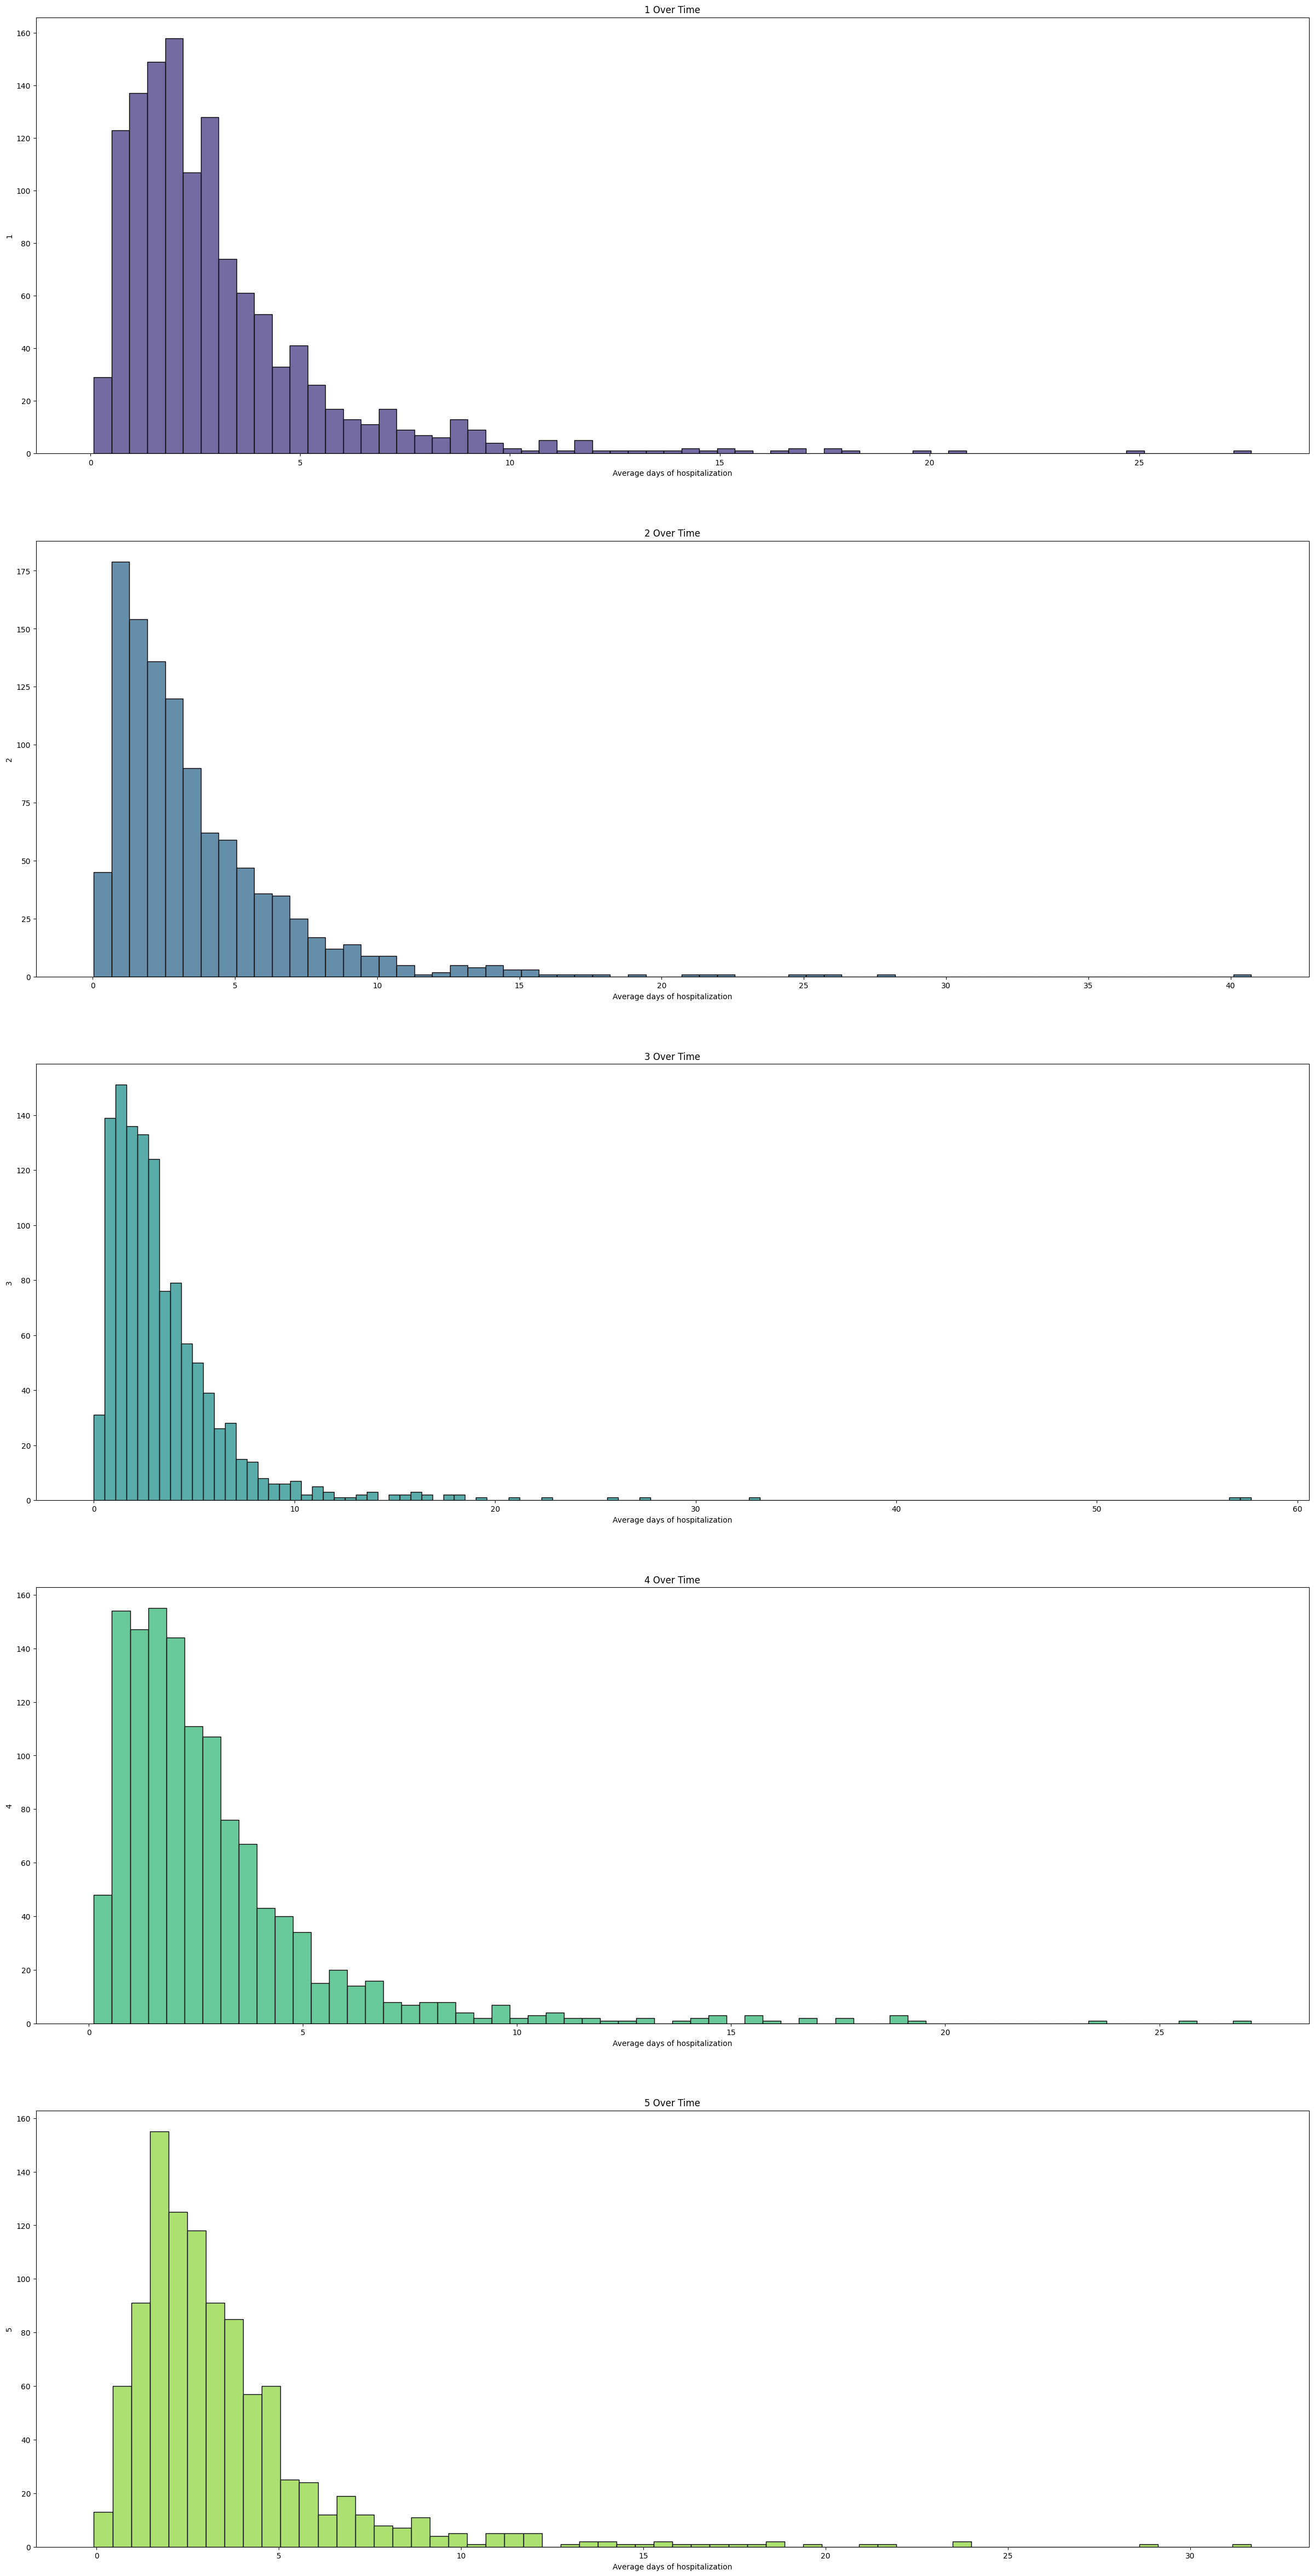

In [11]:
num_cols = len(daily_average.columns)
palette = sns.color_palette('viridis', num_cols)

fig, axes = plt.subplots(num_cols, 1, figsize=(30, 12 * num_cols))

for i, (col, color) in enumerate(zip(daily_average.columns, palette)):
    sns.histplot(data=daily_average[col], ax=axes[i], color=color)
    axes[i].set_title(f'{col} Over Time')
    axes[i].set_xlabel('Average days of hospitalization')
    axes[i].set_ylabel(col)

plt.show()

As we can see, for every feature in the dataset there are missing values.
As a part of the preprocessing for the training process I'll complete the missing values. 
But I want to see before the explore the data with the missing values to be able to check the data for seasonality and cyclic intervals.

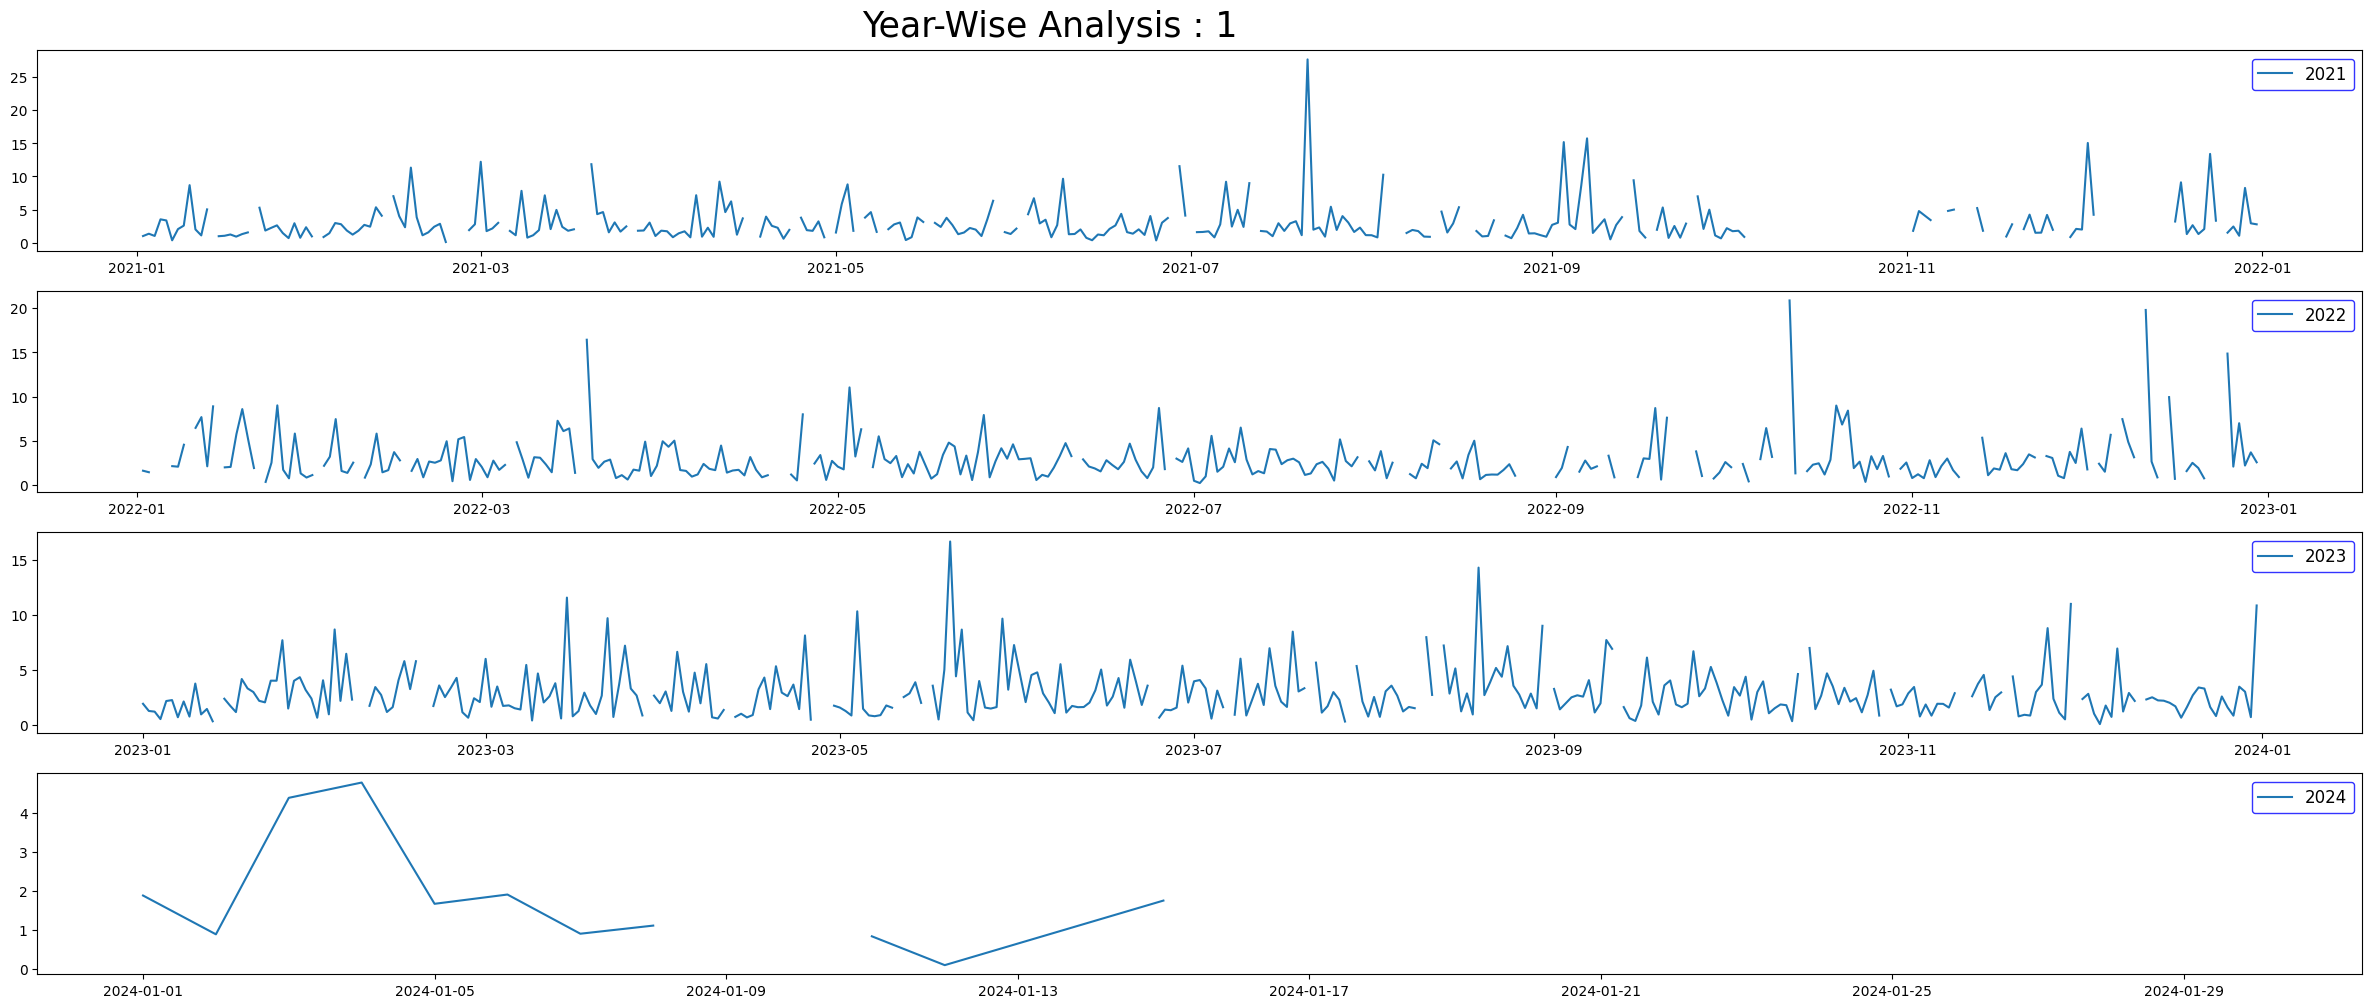

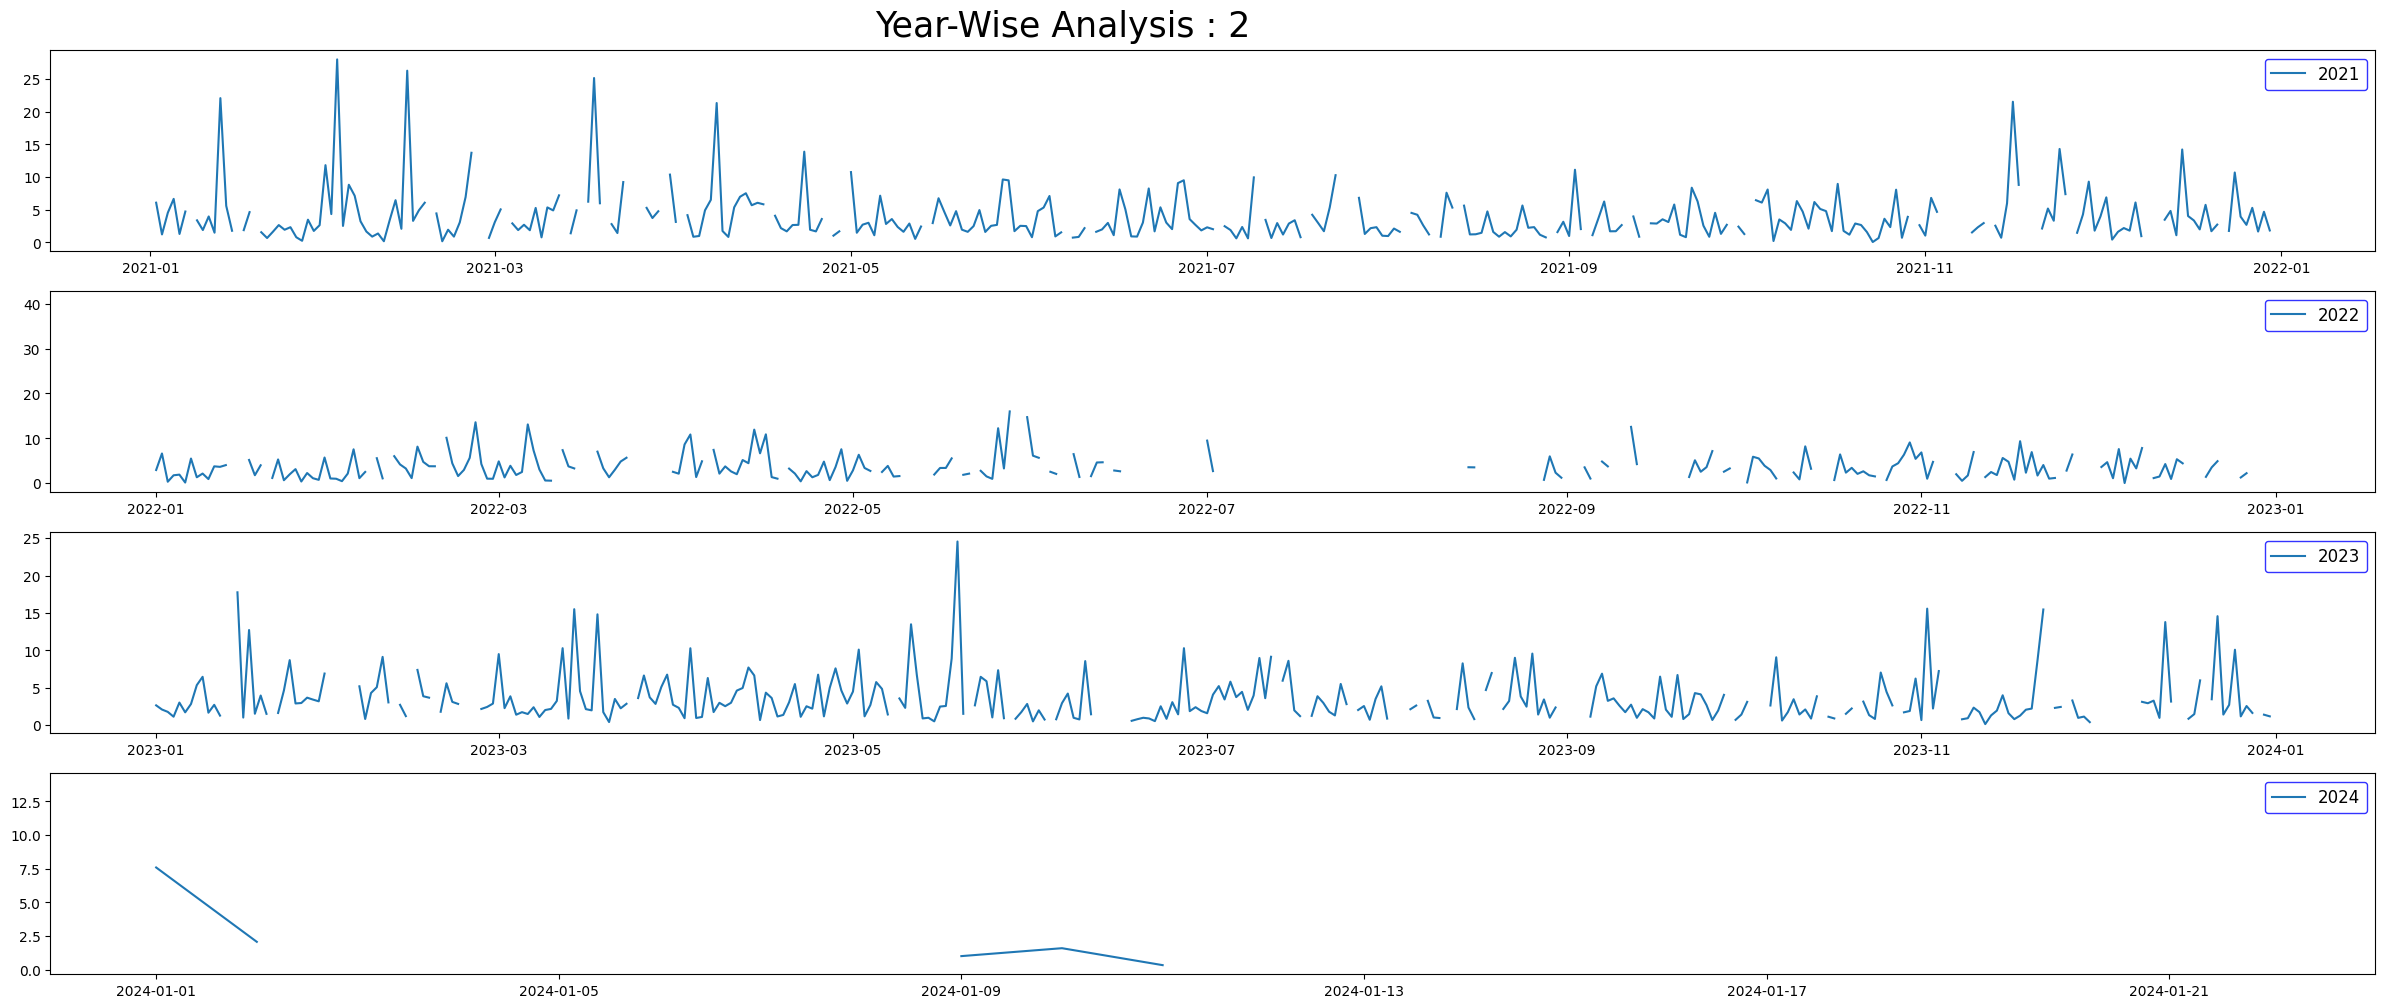

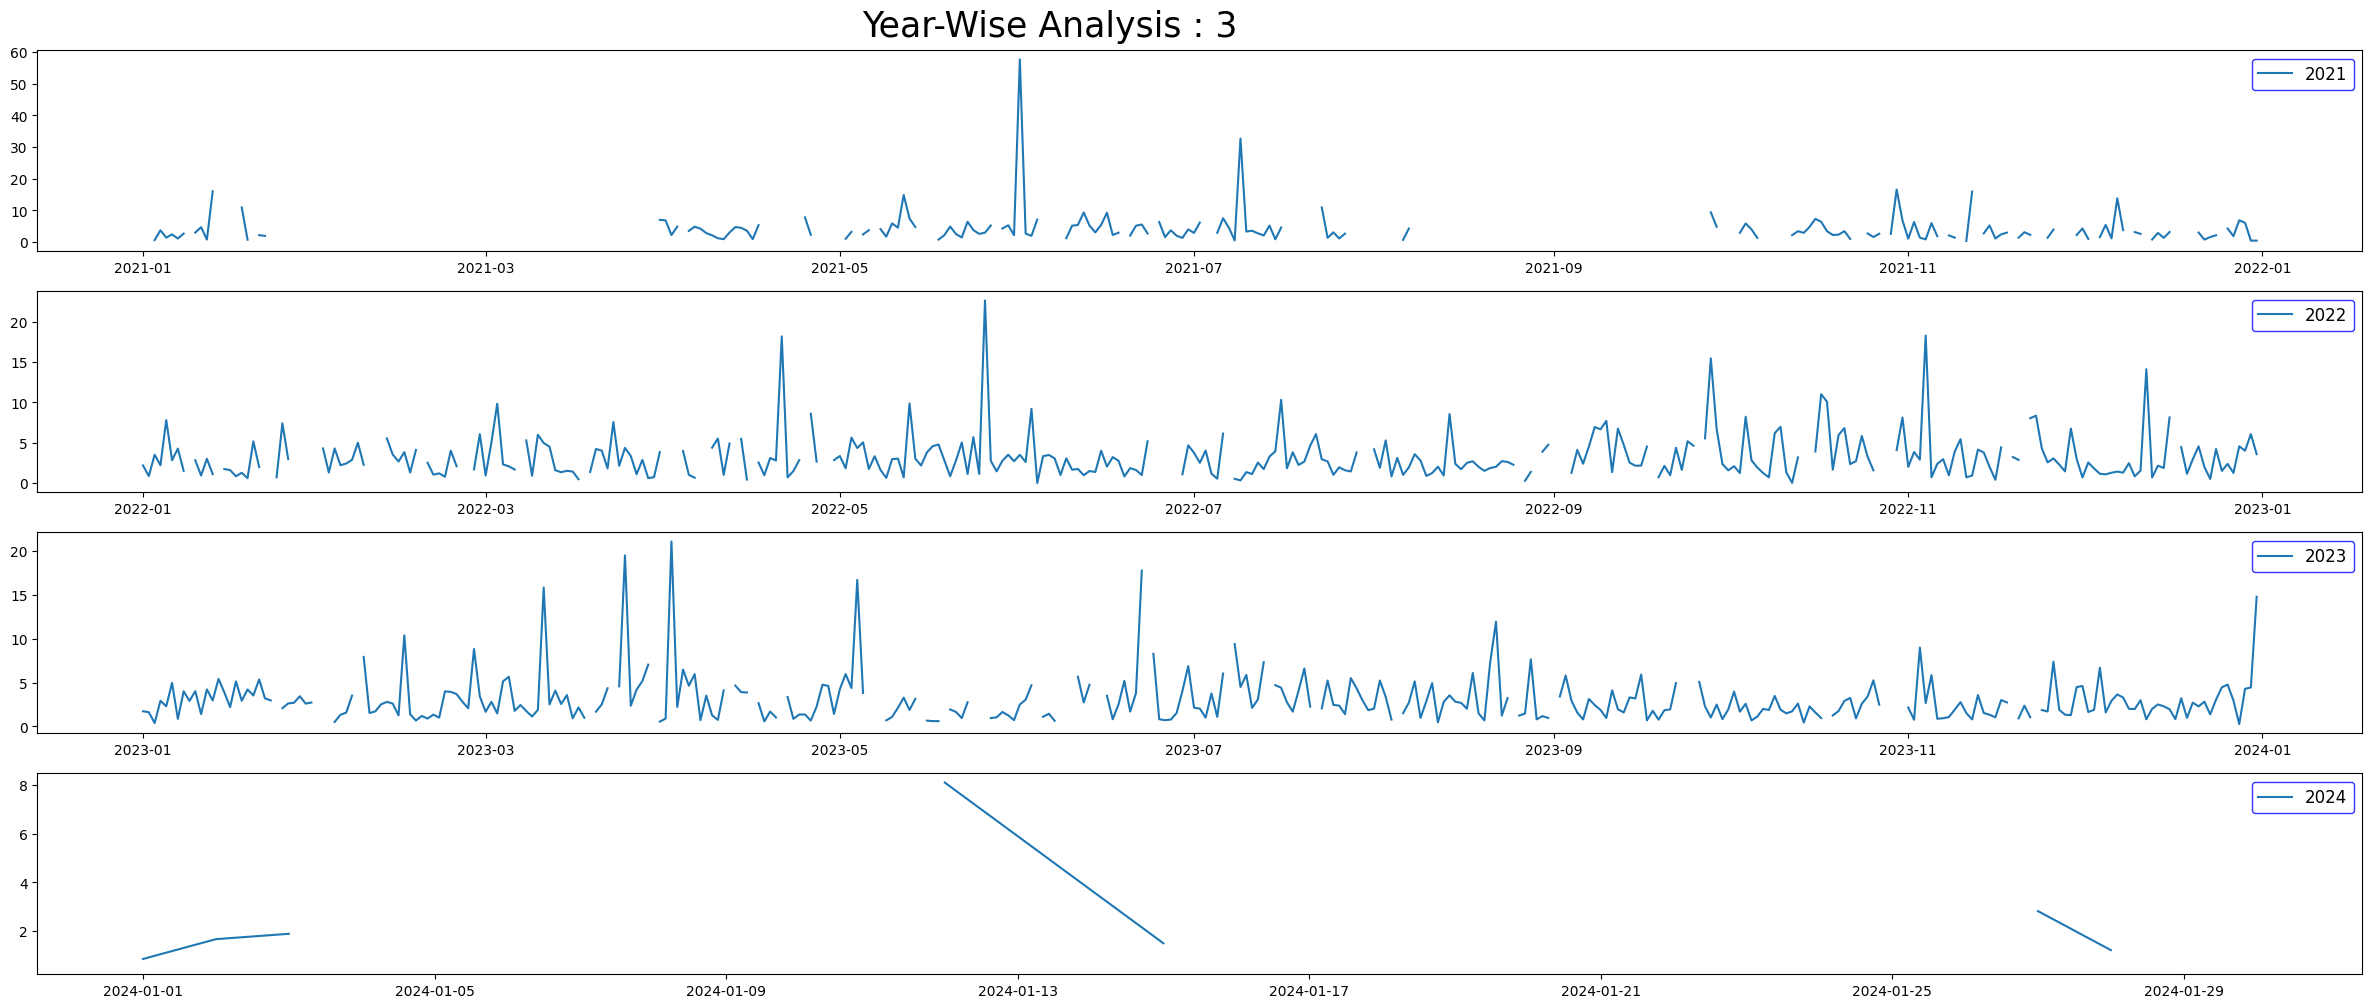

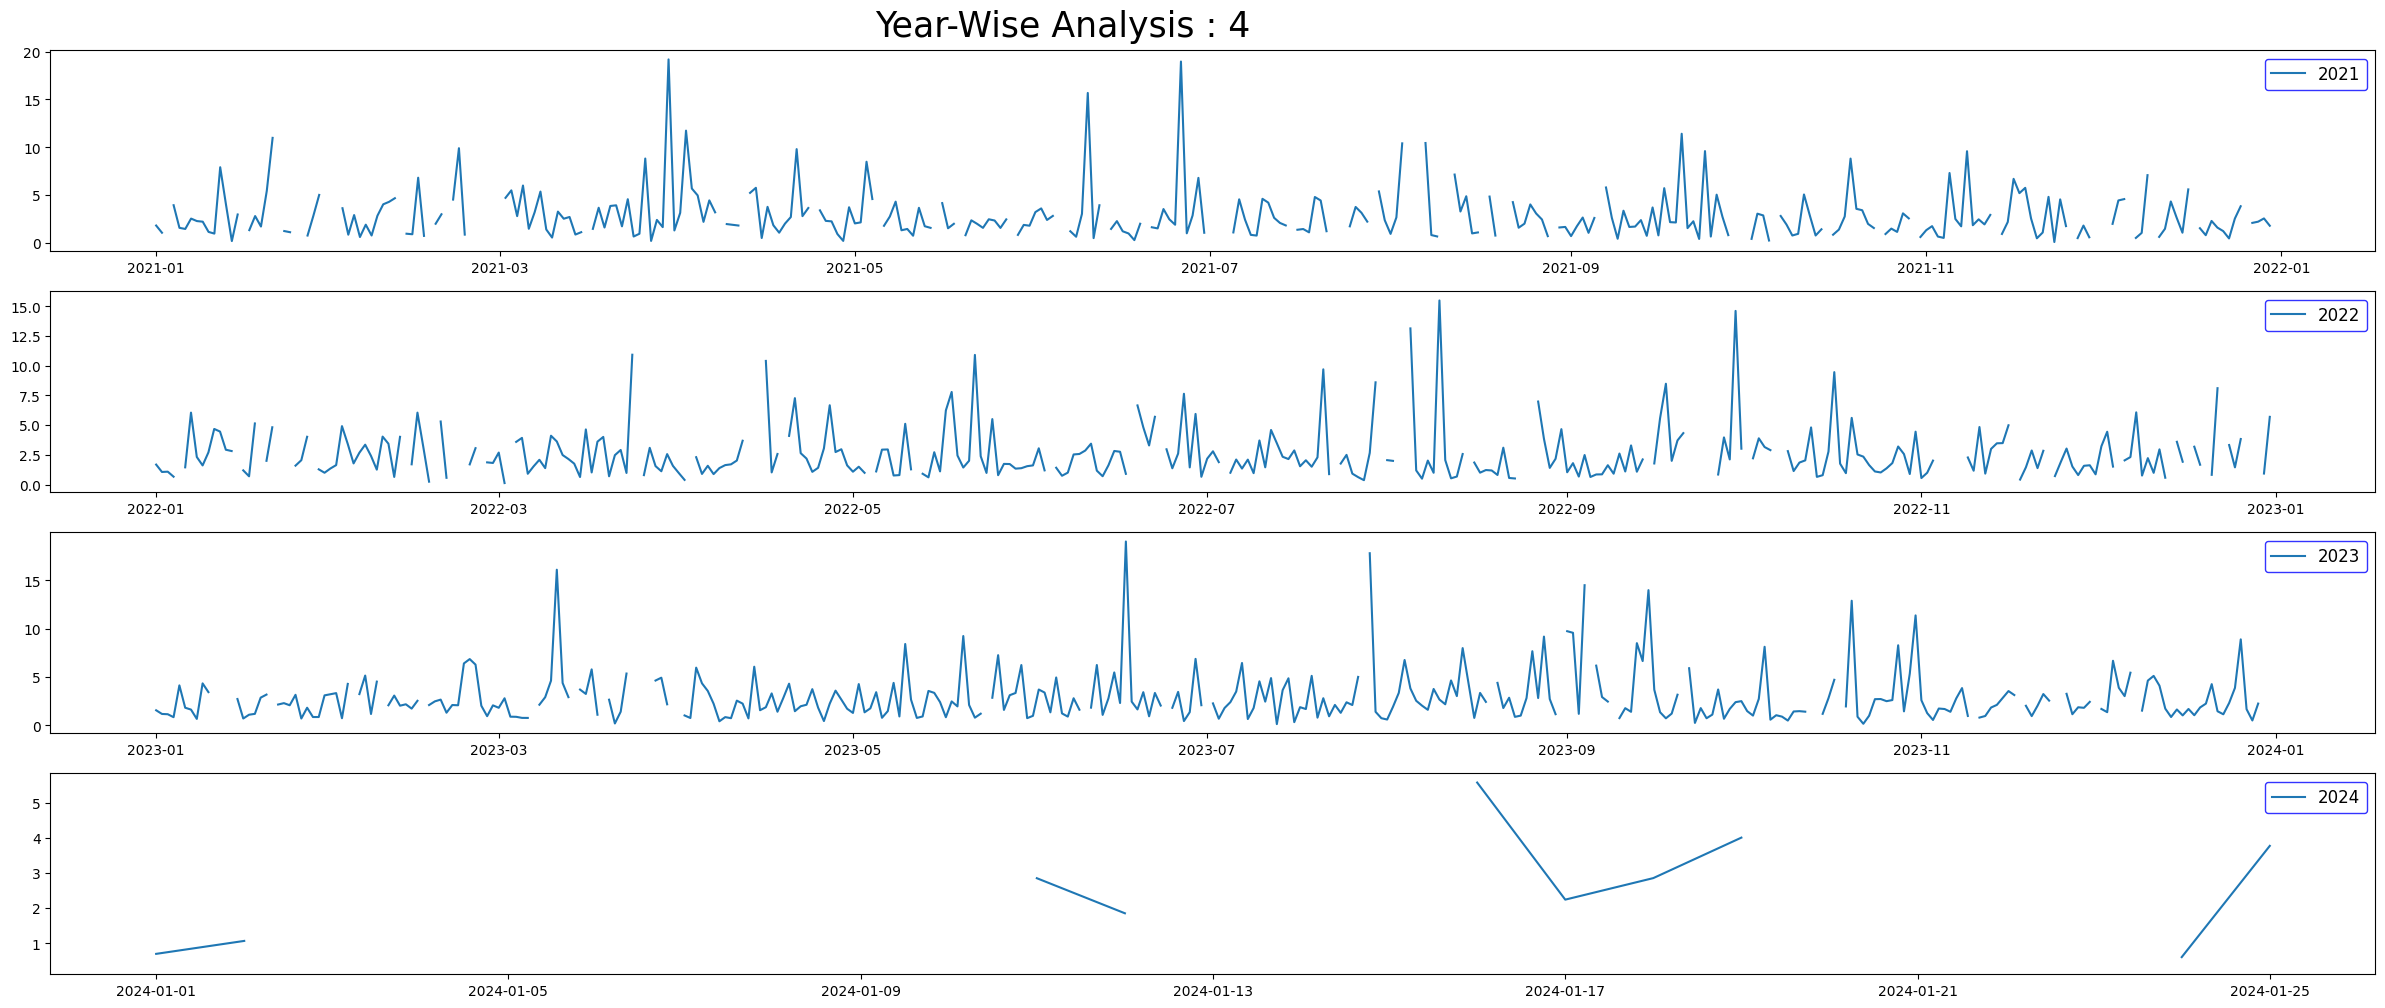

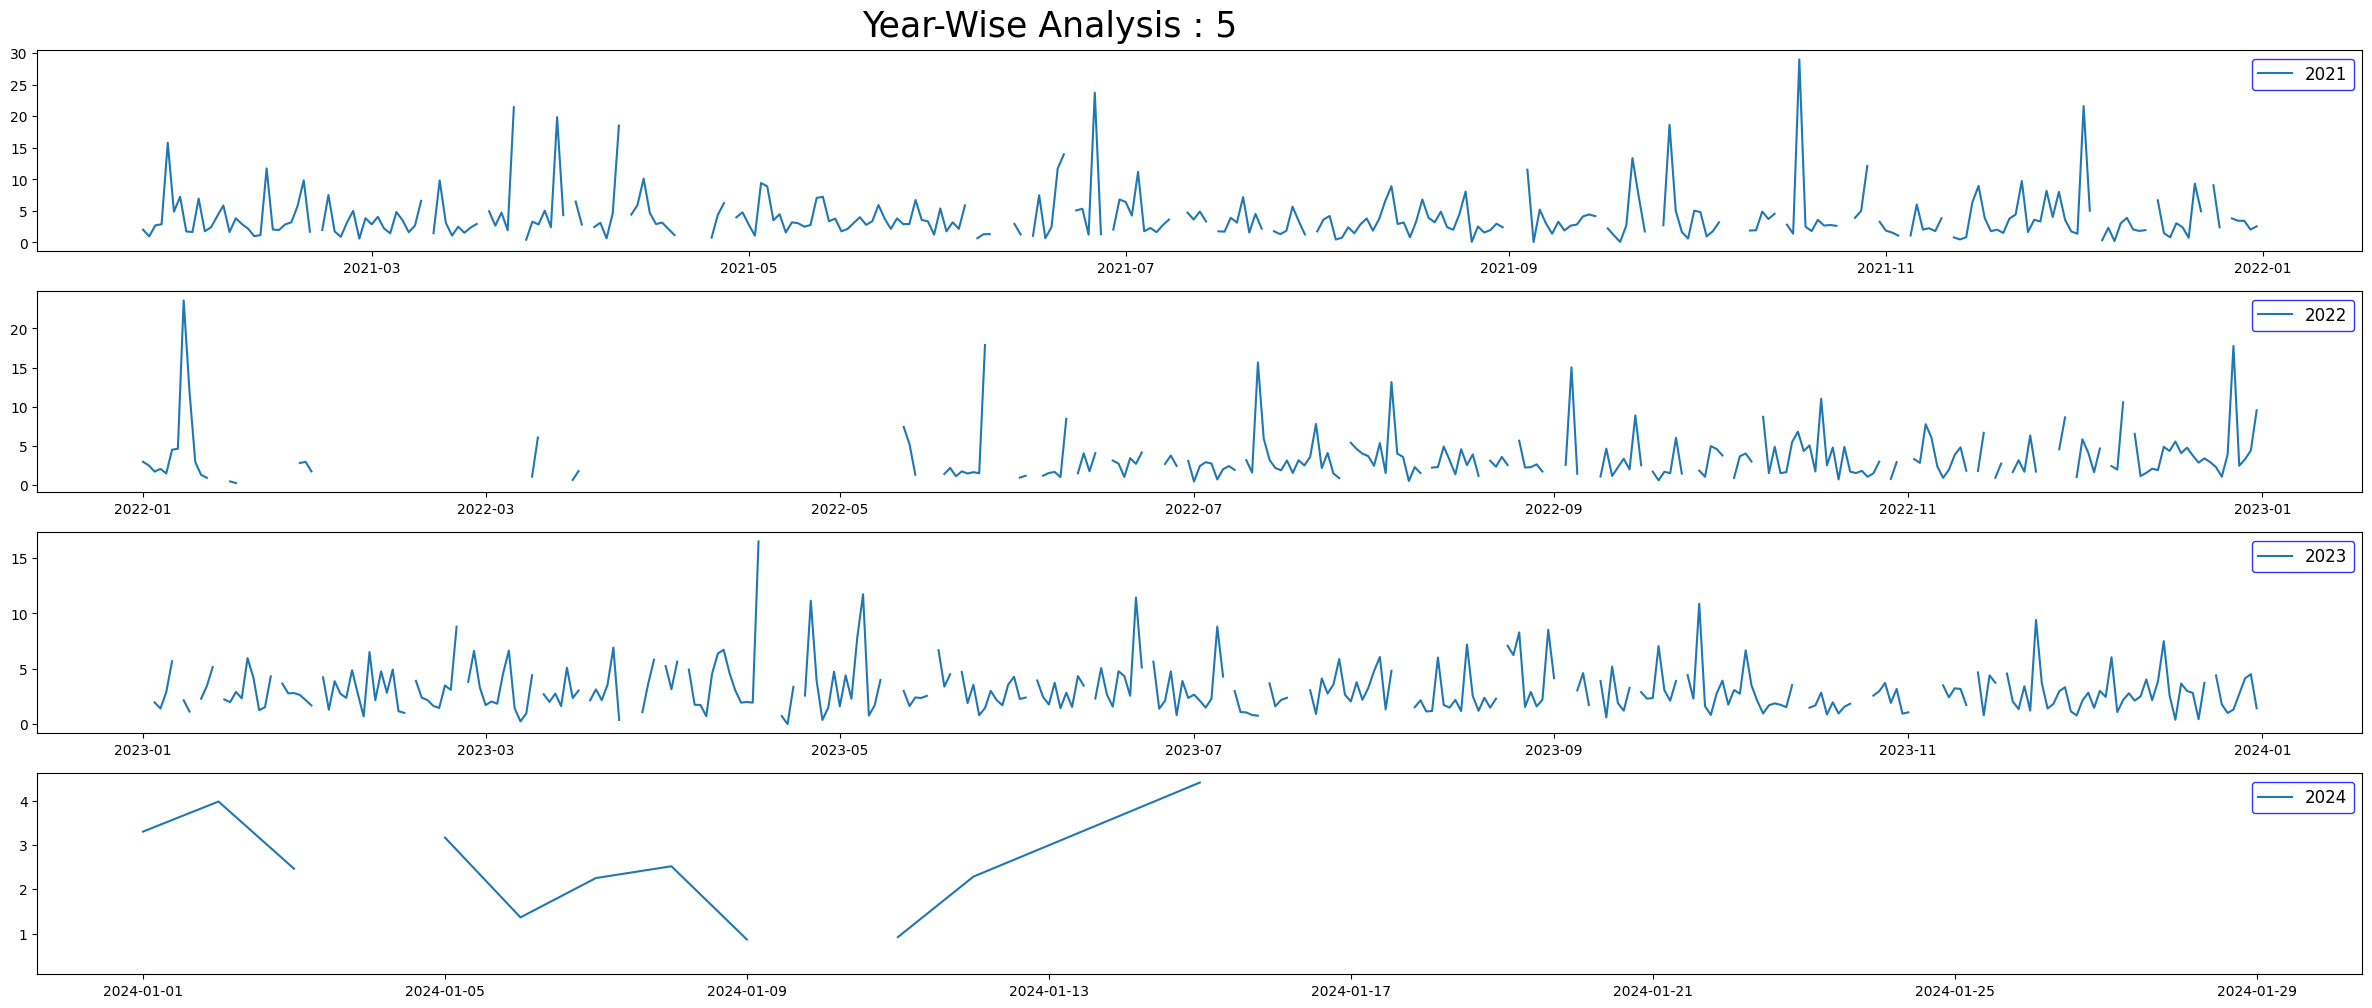

In [12]:
for feat_name in daily_average.columns:    
    fig, axis = plt.subplots(4, 1, figsize=(30, 12))

    for i, d in enumerate(zip(axis, list(daily_average[feat_name].groupby(daily_average.index.year))[1:])):
        d[0].plot(pd.DataFrame(d[1][1]), label=d[1][0])
        d[0].legend(loc='upper right', fontsize='12', frameon=True).get_frame().set_edgecolor('blue') 
    
    fig.text(0.40, 0.9, 'Year-Wise Analysis : %s ' %feat_name, va='center',  fontdict={'fontsize': 25})
    plt.show()    

As we see, each year has some missing values which influence the data and the ability yo apply time series analysis on the data

After analyzing the data with missing values, I'll replace the missing values of each feature with its' mean value for the relative year.

In [13]:
data = []
for d in list(daily_average.groupby(daily_average.index.year)):
    data.append(d[1].fillna(d[1].mean()))

daily_average = pd.DataFrame(np.vstack(data), index=daily_average.index, columns=daily_average.columns)    

In [14]:
daily_average.head()

unitName           1          2         3         4         5
2020-01-01  0.582816   3.326304  3.823915  0.700472  3.999725
2020-01-02  4.641057   3.636320  3.823915  4.207562  4.847385
2020-01-03  3.517399   1.972566  4.581525  3.427117  2.843201
2020-01-04  1.411441   1.416495  3.823915  2.588053  4.339946
2020-01-05  3.278063  17.251184  1.906616  3.434630  3.999725

In [15]:
daily_average.isnull().sum()

unitName
1    0
2    0
3    0
4    0
5    0
dtype: int64

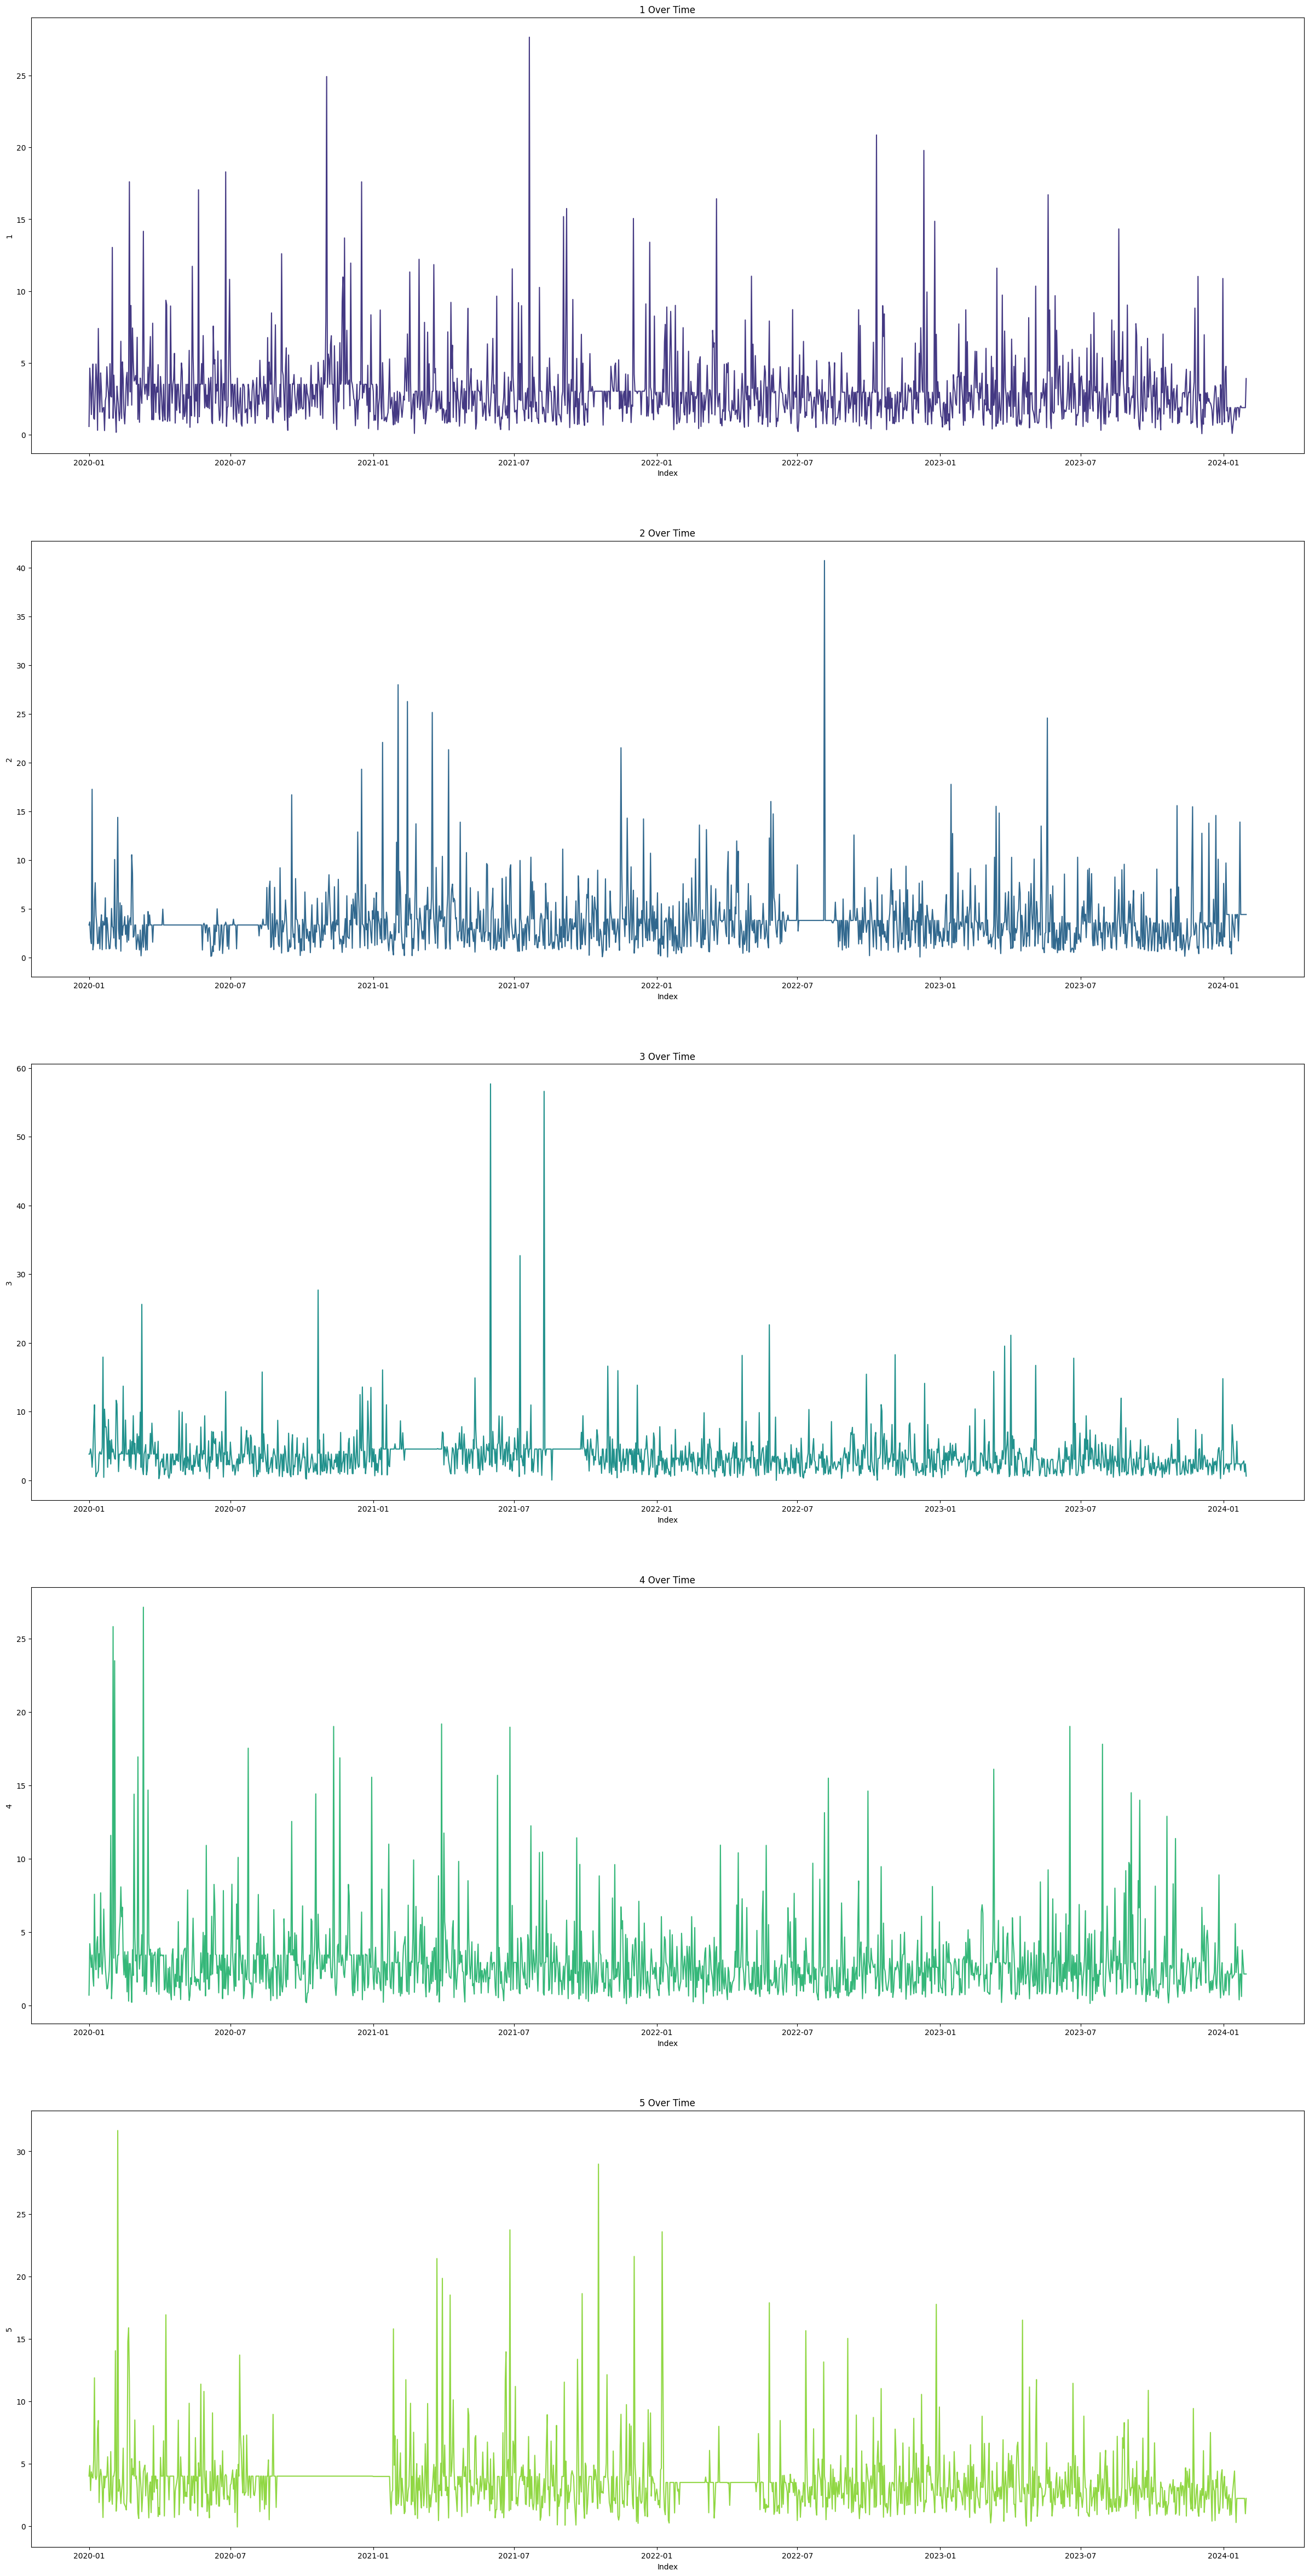

In [16]:
num_cols = len(daily_average.columns)
palette = sns.color_palette('viridis', num_cols)

fig, axes = plt.subplots(num_cols, 1, figsize=(30, 12 * num_cols))

for i, (col, color) in enumerate(zip(daily_average.columns, palette)):
    sns.lineplot(data=daily_average[col], ax=axes[i], color=color)
    axes[i].set_title(f'{col} Over Time')
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(col)

plt.show()

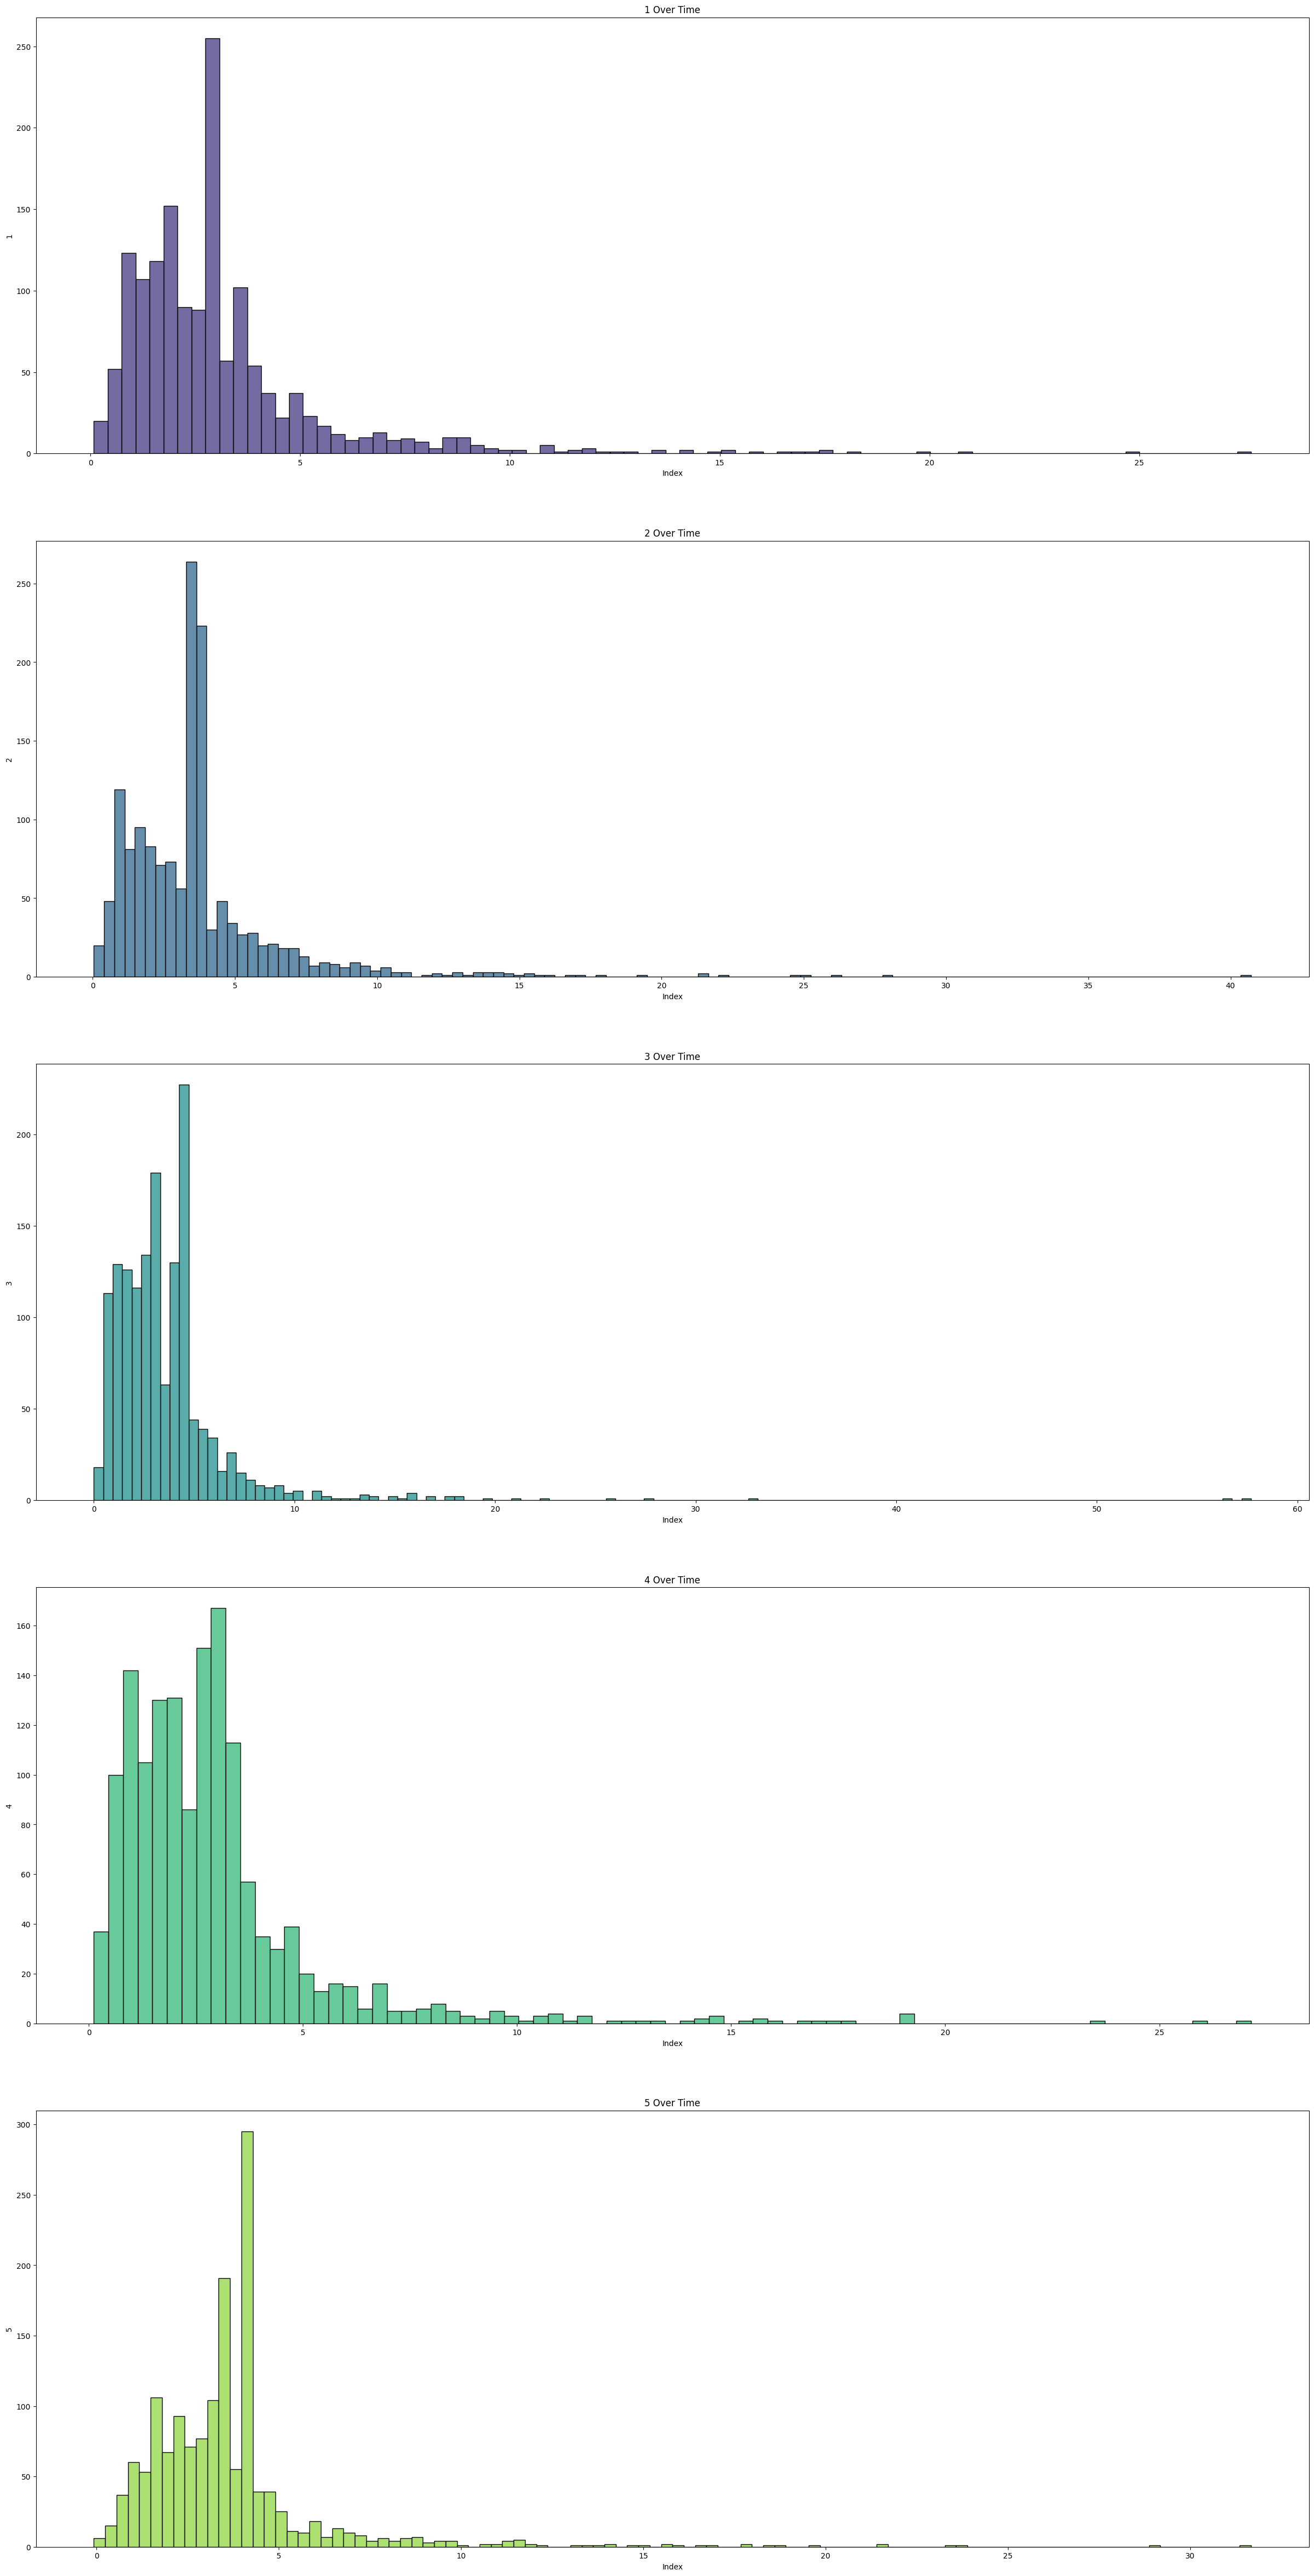

In [17]:
num_cols = len(daily_average.columns)
palette = sns.color_palette('viridis', num_cols)

fig, axes = plt.subplots(num_cols, 1, figsize=(30, 12 * num_cols))

for i, (col, color) in enumerate(zip(daily_average.columns, palette)):
    sns.histplot(data=daily_average[col], ax=axes[i], color=color)
    axes[i].set_title(f'{col} Over Time')
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(col)

plt.show()

Plot Functions:

In [18]:
def plot_loss_over_training(history):
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend(loc='upper right')
  plt.show()

def plot_preds_and_true(y_pred, y_true):
  plt.figure(figsize=(15, 5))
  plt.plot(y_pred, label='Predictions')
  plt.plot(y_true, label='True Values')
  plt.title('True Values vs Predictions')
  plt.xlabel('Time')
  plt.ylabel('Power Consumption')
  plt.legend()
  plt.show()

Data preparation:

In [19]:
SPLIT =  int(len(daily_average) * 0.8)
def data_split(data):
    split = SPLIT
    train = data[:-split]
    test = data[-split:]
    print('data_split finish')
    return train, test

In [20]:
SEQ_LENGTH = 30
def create_seq(data):
    sequences = []
    targets = []
    for i in range(len(data) - SEQ_LENGTH):
        seq = data[i:i + SEQ_LENGTH]
        target = data[i + SEQ_LENGTH]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [21]:
# Define the function to create lag features and date-related features
def create_features(df):
    df['day'] = df.index.day
    #df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year

    # Create lag features for each unit column
    for lag in range(1, 4):
        df[f'lag_{lag}'] = df.iloc[:, 0].shift(lag)  # Shift the target variable (first column)

    df.dropna(inplace=True)
    return df

In [22]:
# Function to plot predictions and true values
def plot_preds_and_true(y_pred, y_true):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_pred)), y_pred, label='Predicted', marker='o')
    plt.plot(range(len(y_true)), y_true, label='True', marker='o')
    plt.title('Predictions vs True Values')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

Linear Regression:


Processing unit: 1
data_split finish
----- Unit 1 values: -----
Mean Absolute Error (LR): 1.7306057062826208
Mean Squared Error (LR): 7.014991111224089
Root Mean Squared Error (LR): 2.648582849605443
R-squared (LR): -0.07846090105761805
Last three predictions: [4.37028738 4.41050506 4.45072274]
Last three true values: [1.8911466  1.8911466  3.91521771]


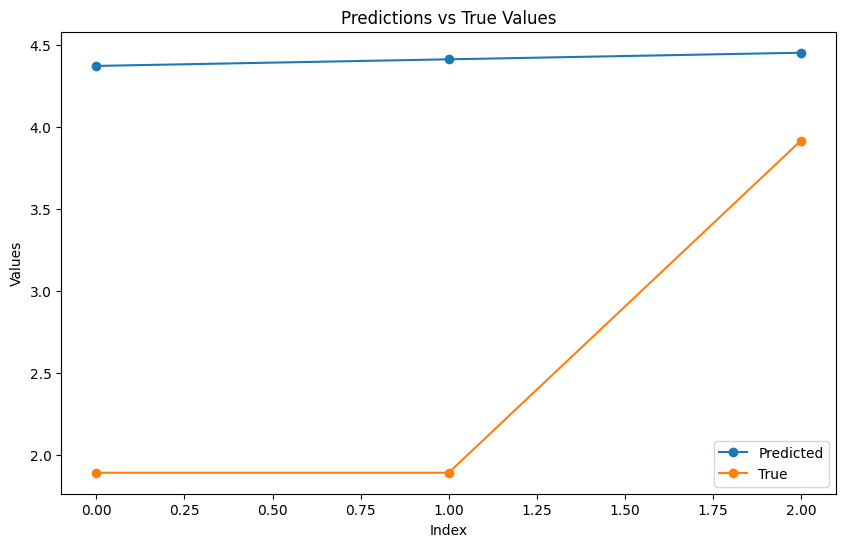


Processing unit: 2
data_split finish
----- Unit 2 values: -----
Mean Absolute Error (LR): 1.9593563973796924
Mean Squared Error (LR): 10.982474995842821
Root Mean Squared Error (LR): 3.3139817434383705
R-squared (LR): -0.06817469338832916
Last three predictions: [3.3562435  3.35617606 3.35610862]
Last three true values: [4.40200507 4.40200507 4.40200507]


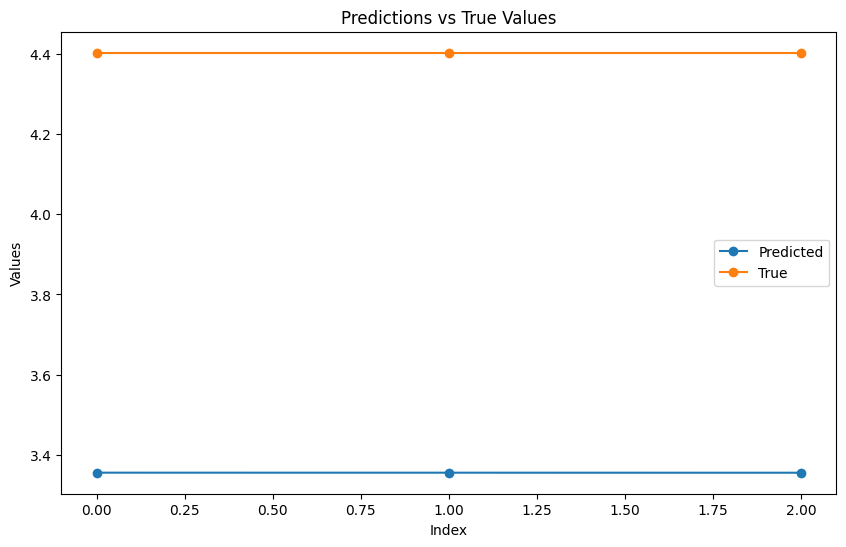


Processing unit: 3
data_split finish
----- Unit 3 values: -----
Mean Absolute Error (LR): 1.9279999025808163
Mean Squared Error (LR): 12.524497817588959
Root Mean Squared Error (LR): 3.538996724721423
R-squared (LR): -0.05611158999654742
Last three predictions: [5.1192554  5.24767419 5.09350256]
Last three true values: [1.22513436 2.39182711 0.61005922]


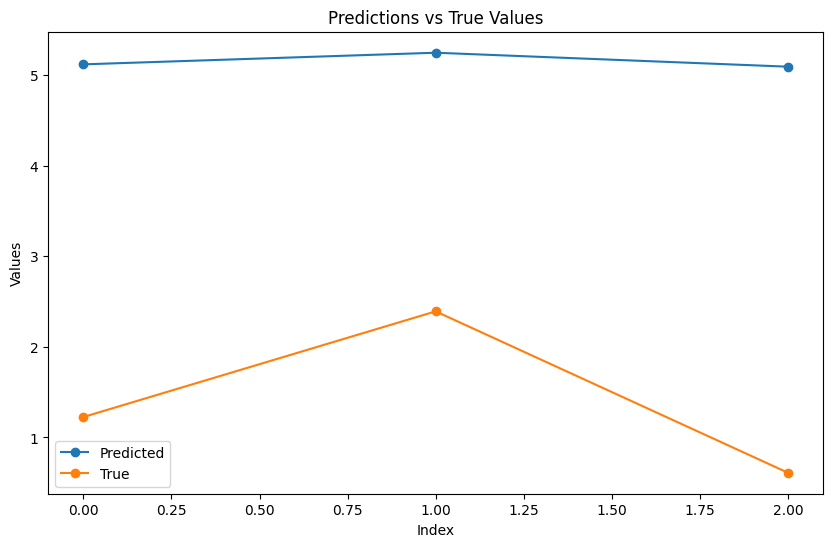


Processing unit: 4
data_split finish
----- Unit 4 values: -----
Mean Absolute Error (LR): 1.7235474454427637
Mean Squared Error (LR): 6.425904594435458
Root Mean Squared Error (LR): 2.5349368028484376
R-squared (LR): -0.11967652535696427
Last three predictions: [3.37770788 3.20448295 3.13093345]
Last three true values: [2.14129431 2.14129431 2.14129431]


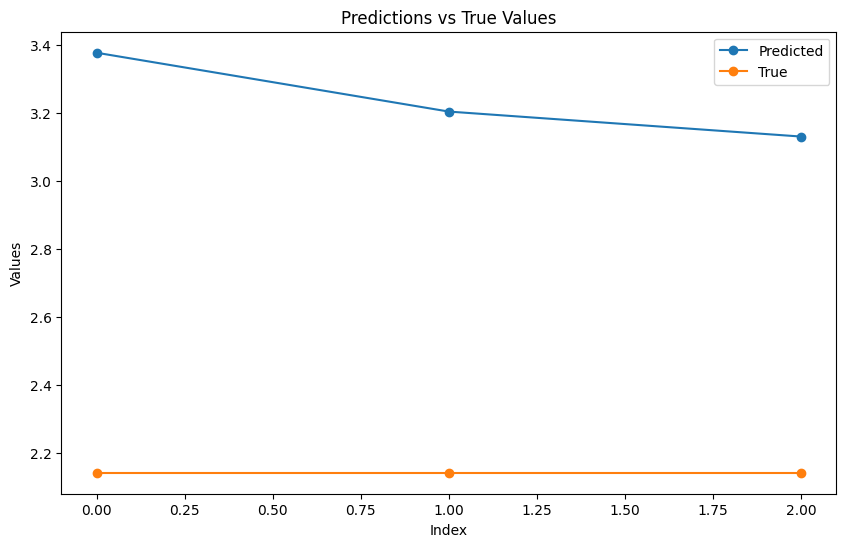


Processing unit: 5
data_split finish
----- Unit 5 values: -----
Mean Absolute Error (LR): 1.660930902021451
Mean Squared Error (LR): 7.105351949967846
Root Mean Squared Error (LR): 2.665586605227421
R-squared (LR): -0.0521782209798165
Last three predictions: [4.09760135 4.09094075 3.99832017]
Last three true values: [2.21490295 0.98726149 2.21490295]


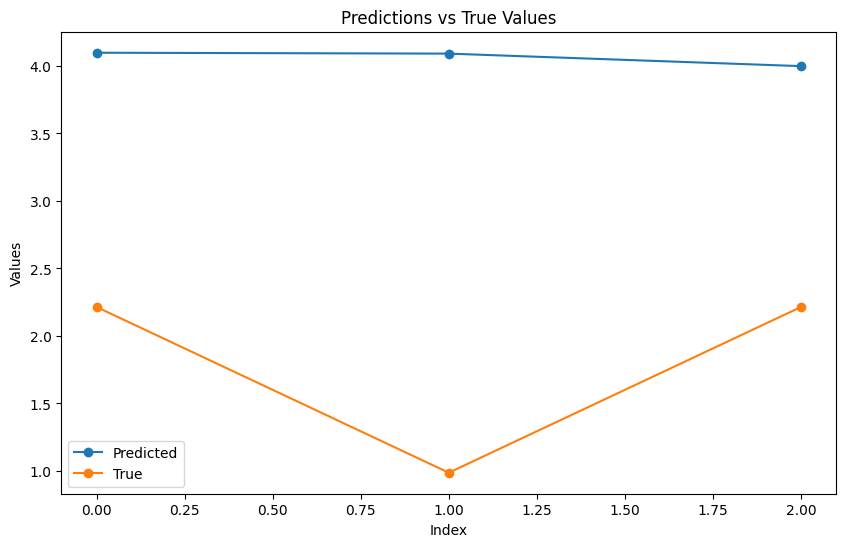

In [23]:
# Loop over each unit column
for unit in daily_average.columns:
    print(f'\nProcessing unit: {unit}')
    
    # Split data into train and test
    train, test = data_split(daily_average[[unit]])

    # Create features
    train_lr = create_features(train.copy())
    test_lr = create_features(test.copy())

    # Define features for the model
    features = [f'lag_{lag}' for lag in range(1, 4)]
    features.append('year')
    features.append('month')
    #features.append('day_of_week')
    features.append('day')

    # Prepare the train and test datasets
    x_train = train_lr[features]
    y_train = train_lr[unit]
    x_test = test_lr[features]
    y_test = test_lr[unit]

    # Fit the Linear Regression model
    lr = LinearRegression()
    lr.fit(x_train, y_train)

    # Predict and evaluate
    y_pred = lr.predict(x_test)
    y_test_lr = y_test.values

    mse = mean_squared_error(y_test_lr, y_pred)
    mae = mean_absolute_error(y_test_lr, y_pred)
    r2 = r2_score(y_test_lr, y_pred)
    rmse = np.sqrt(mse)

    print(f'----- Unit {unit} values: -----')
    print(f'Mean Absolute Error (LR): {mae}')
    print(f'Mean Squared Error (LR): {mse}')
    print(f'Root Mean Squared Error (LR): {rmse}')
    print(f'R-squared (LR): {r2}')

    # Display the last three predictions and true values
    pred_last_3 = y_pred[-3:]
    test_last_3 = y_test_lr[-3:]

    print(f'Last three predictions: {pred_last_3.flatten()}')
    print(f'Last three true values: {test_last_3}')

    # Plot predictions vs true values for the last three points
    plot_preds_and_true(y_pred=pred_last_3, y_true=test_last_3)

Simple RNN:

In [24]:
# Loop over each unit column
for unit in daily_average.columns:
    print(f'\nProcessing unit: {unit}')
    
    # Copy the DataFrame to avoid modifying the original data
    unit_df = daily_average[[unit]].copy()
    
    # Scale the target variable using MinMaxScaler
    scaler = MinMaxScaler()
    unit_df[unit] = scaler.fit_transform(unit_df[[unit]])

    # Create lag features for the scaled data
    scaled_df = create_features(unit_df.copy())

    # Prepare sequences for time series modeling
    X, y = create_seq(scaled_df[unit].values)

    # Split sequences into training and testing sets
    X_train, X_test = data_split(X)
    y_train, y_test = data_split(y)


Processing unit: 1
data_split finish
data_split finish

Processing unit: 2
data_split finish
data_split finish

Processing unit: 3
data_split finish
data_split finish

Processing unit: 4
data_split finish
data_split finish

Processing unit: 5
data_split finish
data_split finish


In [25]:
def create_rnn(X_train, y_train, X_test, y_test):
    rnn = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
        tf.keras.layers.Dense(1)
    ])

    print('Start training')
    rnn.compile(optimizer='adam', loss='mean_squared_error')
    history = rnn.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))
    print('End training')

    test_loss = rnn.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss:.4f}")

    y_pred = rnn.predict(X_test)

    y_pred = scaler.inverse_transform(y_pred)
    y_test_rnn = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_rnn, y_pred)
    mae = mean_absolute_error(y_test_rnn, y_pred)
    r2 = r2_score(y_test_rnn, y_pred)
    rmse = np.sqrt(mse)

    print(f'Mean Absolute Error (RNN): {mae}')
    print(f'Mean Squared Error (RNN): {mse}')
    print(f'Root Mean Squared Error (RNN): {rmse}')
    print(f'R-squared (RNN): {r2}')

    plot_loss_over_training(history)
    plot_preds_and_true(y_pred, y_test_rnn)


Processing unit: 1
data_split finish
data_split finish
Start training
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0321 - val_loss: 0.0220
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0239 - val_loss: 0.0169
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0182 - val_loss: 0.0128
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0135 - val_loss: 0.0094
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0079 - val_loss: 0.0101
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0100 - val_loss: 0.0105
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0099 - val_loss: 0.0089
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0083 - val_loss: 0.0086
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0089 - val_loss: 0.0086
End training
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0113 
Test Loss: 0.0086
38/38 ━━━━━

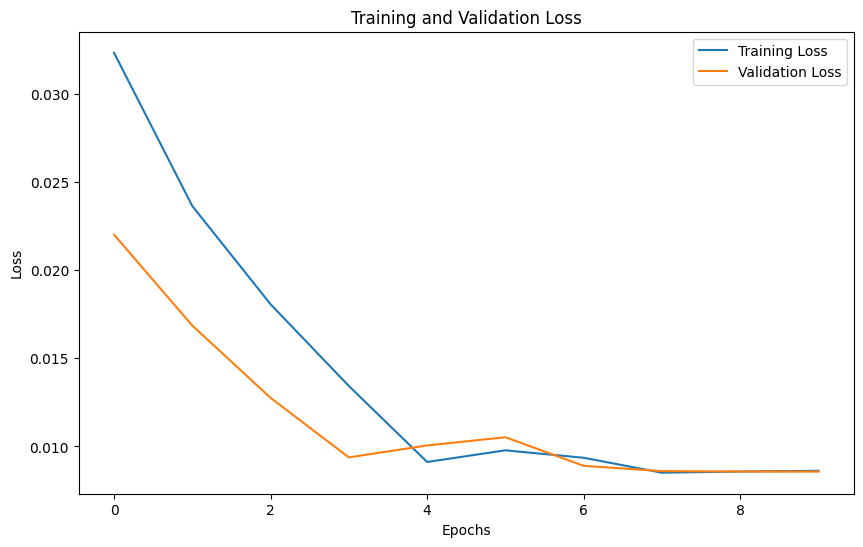

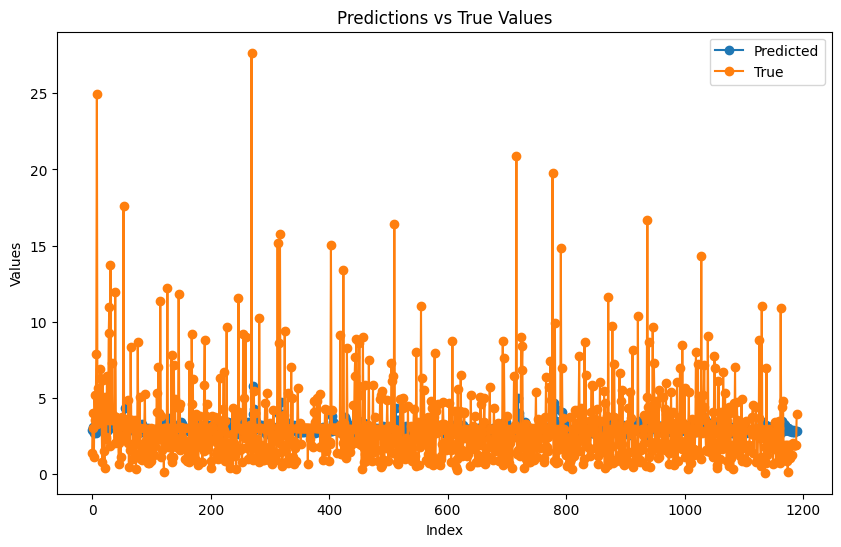


Processing unit: 2
data_split finish
data_split finish
Start training
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0124 - val_loss: 0.0140
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0073 - val_loss: 0.0093
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0034 - val_loss: 0.0067
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0021 - val_loss: 0.0069
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0029 - val_loss: 0.0069
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0025 - val_loss: 0.0066
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0018 - val_loss: 0.0066
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0023 - val_loss: 0.0067
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0019 - val_loss: 0.0067
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0022 - val_loss: 0.0067
End training
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0078 
Test Loss: 0.0067
38/38 ━━━━━

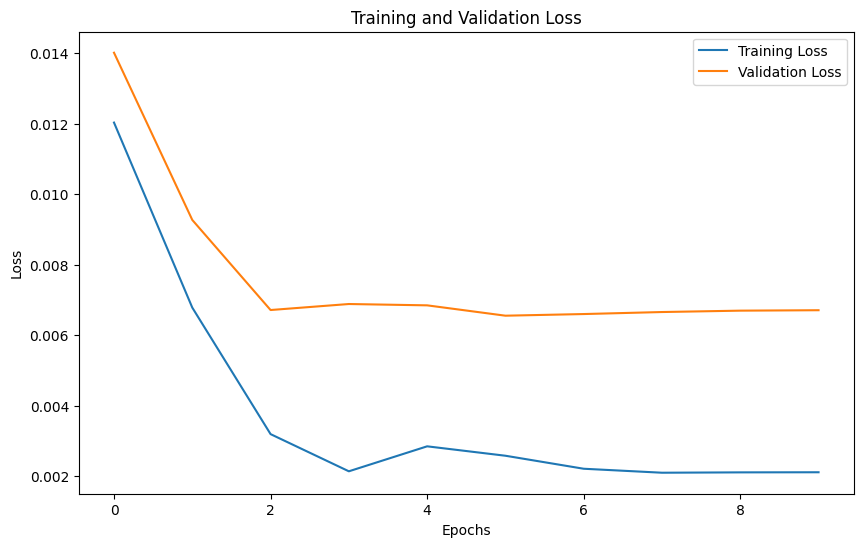

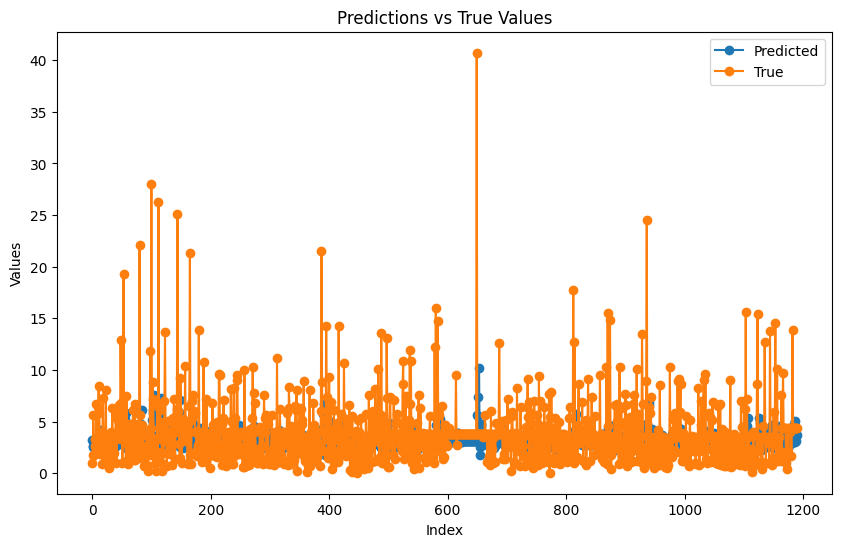


Processing unit: 3
data_split finish
data_split finish
Start training
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0025 - val_loss: 0.0036
End training
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0044 
Test Loss: 0.0036
38/38 ━━━━━

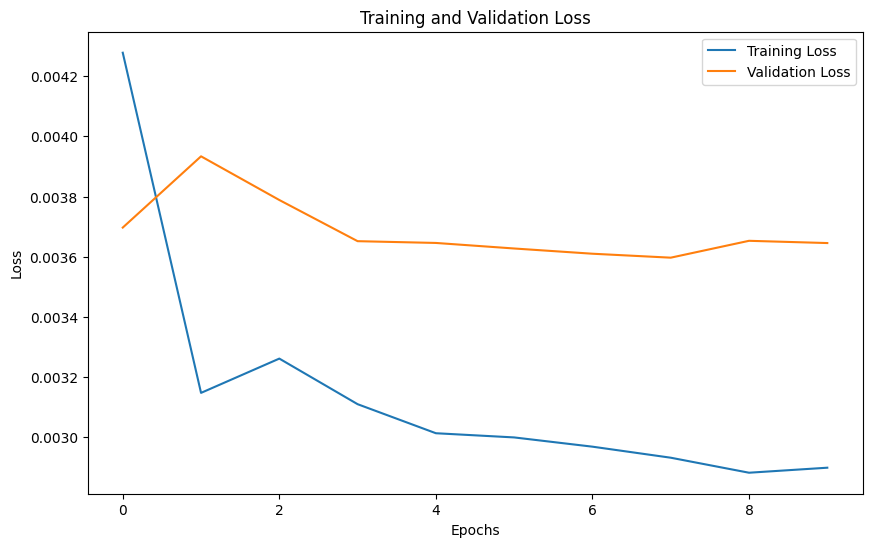

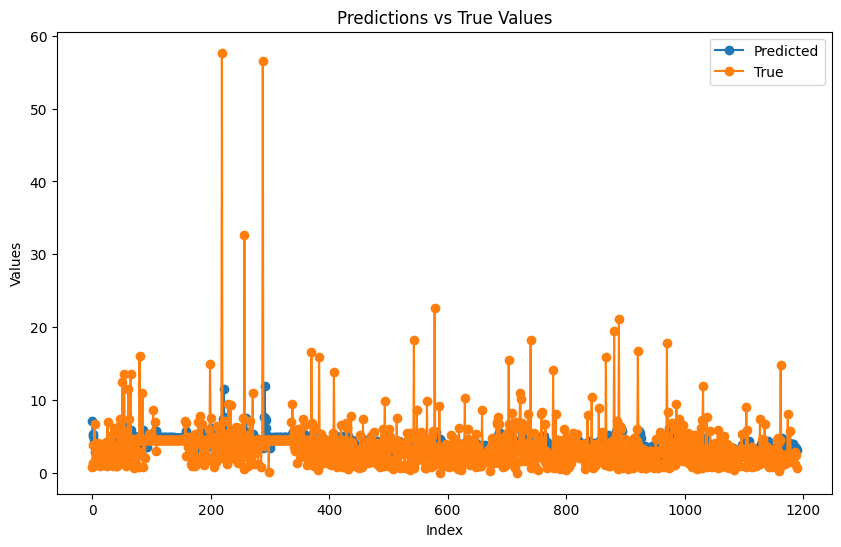


Processing unit: 4
data_split finish
data_split finish
Start training
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0401 - val_loss: 0.0163
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0241 - val_loss: 0.0109
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0197 - val_loss: 0.0091
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0134 - val_loss: 0.0095
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0142 - val_loss: 0.0103
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0154 - val_loss: 0.0096
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0143 - val_loss: 0.0090
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0150 - val_loss: 0.0088
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0120 - val_loss: 0.0087
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0130 - val_loss: 0.0086
End training
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104 
Test Loss: 0.0086
38/38 ━━━━━

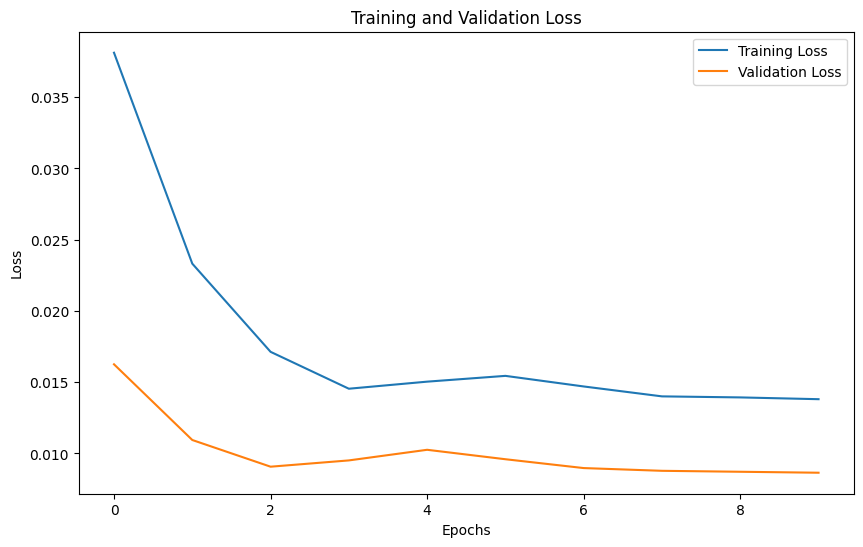

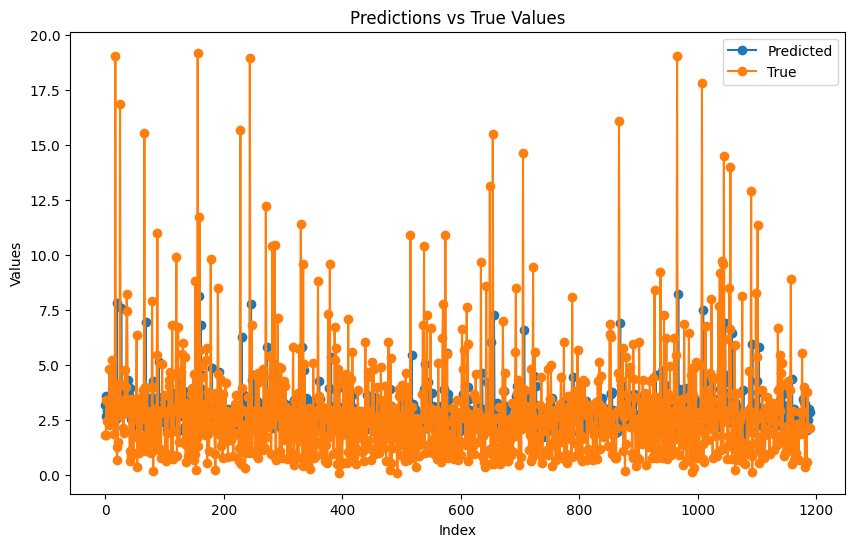


Processing unit: 5
data_split finish
data_split finish
Start training
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0097 - val_loss: 0.0078
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0099 - val_loss: 0.0081
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0106 - val_loss: 0.0081
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0088 - val_loss: 0.0077
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0084 - val_loss: 0.0075
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0090 - val_loss: 0.0075
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0098 - val_loss: 0.0074
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0094 - val_loss: 0.0075
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0098 - val_loss: 0.0077
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0079 - val_loss: 0.0078
End training
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0084     
Test Loss: 0.0078
38/38 ━

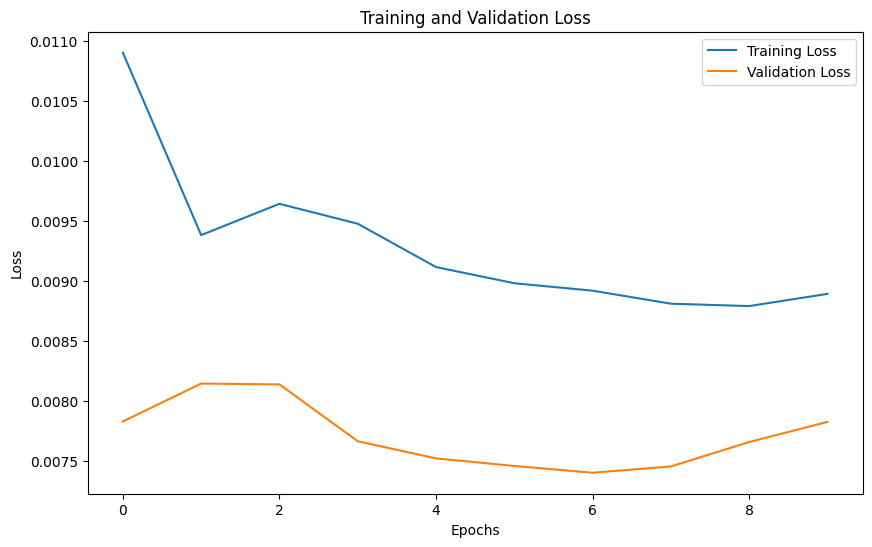

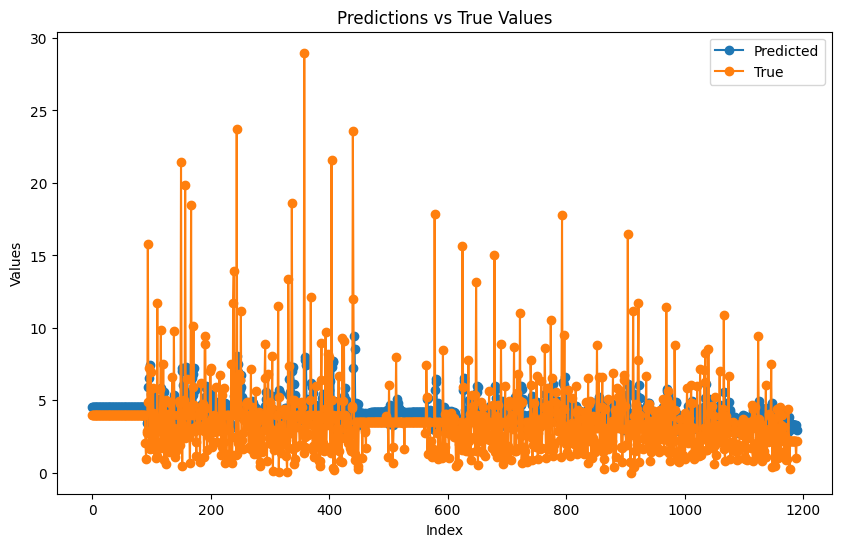

In [26]:
# Loop over each unit column
for unit in daily_average.columns:
    print(f'\nProcessing unit: {unit}')
    
    # Copy the DataFrame to avoid modifying the original data
    unit_df = daily_average[[unit]].copy()
    
    # Scale the target variable using MinMaxScaler
    scaler = MinMaxScaler()
    unit_df[unit] = scaler.fit_transform(unit_df[[unit]])

    # Create lag features for the scaled data
    scaled_df = create_features(unit_df.copy())

    # Prepare sequences for time series modeling
    X, y = create_seq(scaled_df[unit].values)

    # Reshape X for RNN input
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Split sequences into training and testing sets
    X_train, X_test = data_split(X)
    y_train, y_test = data_split(y)

    # Train and evaluate the RNN model
    create_rnn(X_train, y_train, X_test, y_test)

LSTM:

In [27]:
def create_LSTM(X_train, y_train, X_test, y_test):
    lstm = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
        tf.keras.layers.Dense(1)
    ])

    print('Start training')
    lstm.compile(optimizer='adam', loss='mean_squared_error')
    history = lstm.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))
    print('End training')

    test_loss = lstm.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss:.4f}")

    y_pred = lstm.predict(X_test)

    y_pred = scaler.inverse_transform(y_pred)
    y_test_lstm = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_lstm, y_pred)
    mae = mean_absolute_error(y_test_lstm, y_pred)
    r2 = r2_score(y_test_lstm, y_pred)
    rmse = np.sqrt(mse)

    print(f'Mean Absolute Error (LSTM): {mae}')
    print(f'Mean Squared Error (LSTM): {mse}')
    print(f'Root Mean Squared Error (LSTM): {rmse}')
    print(f'R-squared (LSTM): {r2}')

    plot_loss_over_training(history)
    plot_preds_and_true(y_pred, y_test_lstm)


Processing unit: 1
data_split finish
data_split finish
Start training
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0224 - val_loss: 0.0161
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0173 - val_loss: 0.0126
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0134 - val_loss: 0.0100
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0103 - val_loss: 0.0086
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0078 - val_loss: 0.0090
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0096 - val_loss: 0.0099
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0099 - val_loss: 0.0093
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0091 - val_loss: 0.0087
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0081 - val_loss: 0.0086
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0090 - val_loss: 0.0085
End training
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112
Test Loss: 0.0085
38/38 ━━━━━━

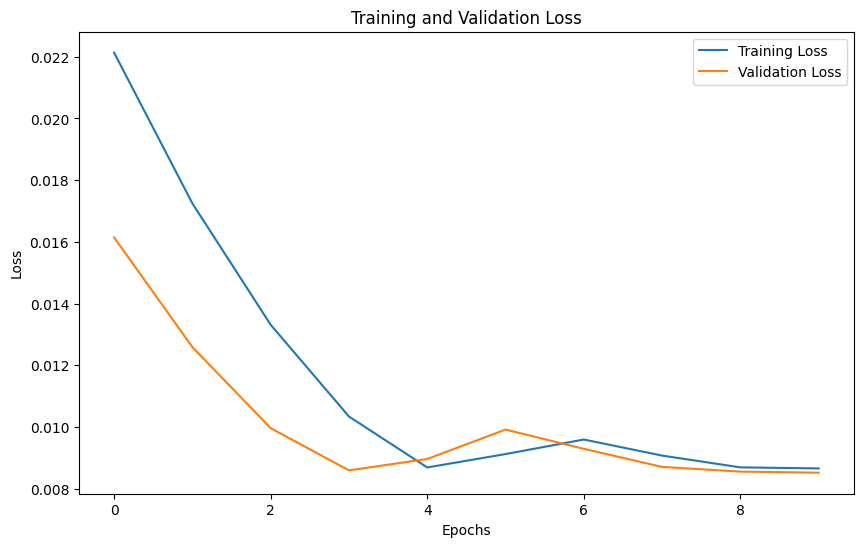

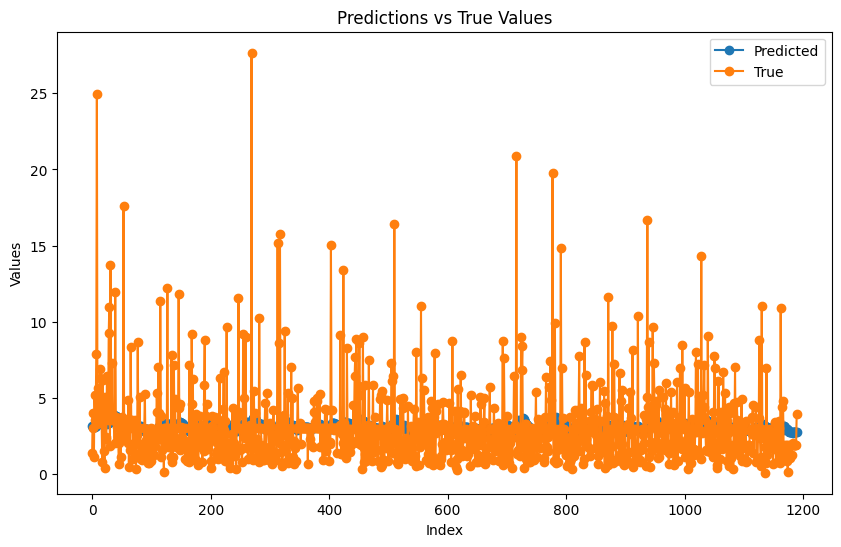


Processing unit: 2
data_split finish
data_split finish
Start training
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0075 - val_loss: 0.0105
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0042 - val_loss: 0.0078
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0027 - val_loss: 0.0064
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0024 - val_loss: 0.0063
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0026 - val_loss: 0.0064
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0026 - val_loss: 0.0063
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0023 - val_loss: 0.0062
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0022 - val_loss: 0.0064
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0021 - val_loss: 0.0064
End training
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074
Test Loss: 0.0064
38/38 ━━━━━━

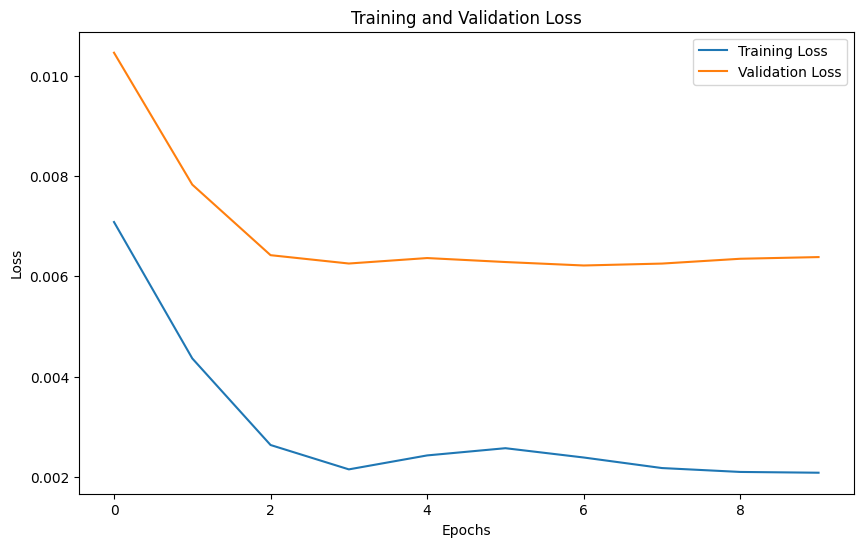

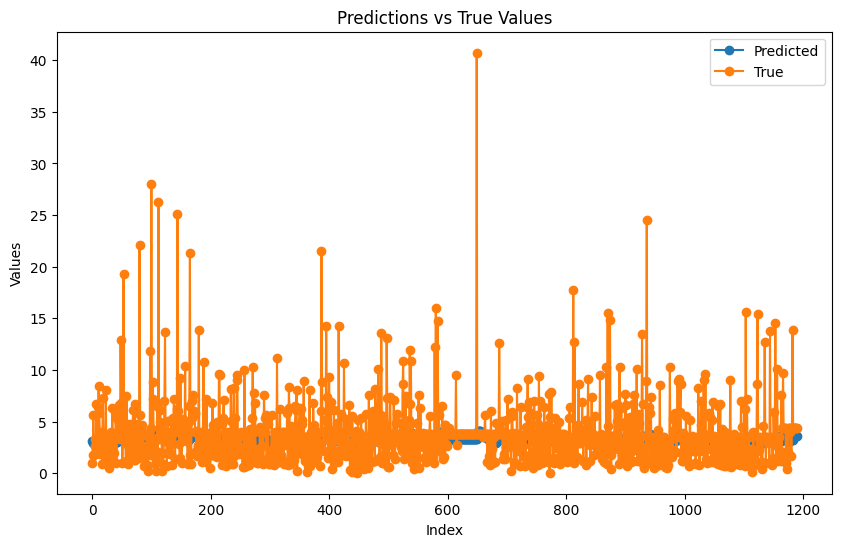


Processing unit: 3
data_split finish
data_split finish
Start training
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0075 - val_loss: 0.0061
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0060 - val_loss: 0.0047
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0033 - val_loss: 0.0035
End training
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043    
Test Loss: 0.0035
38/38 ━━

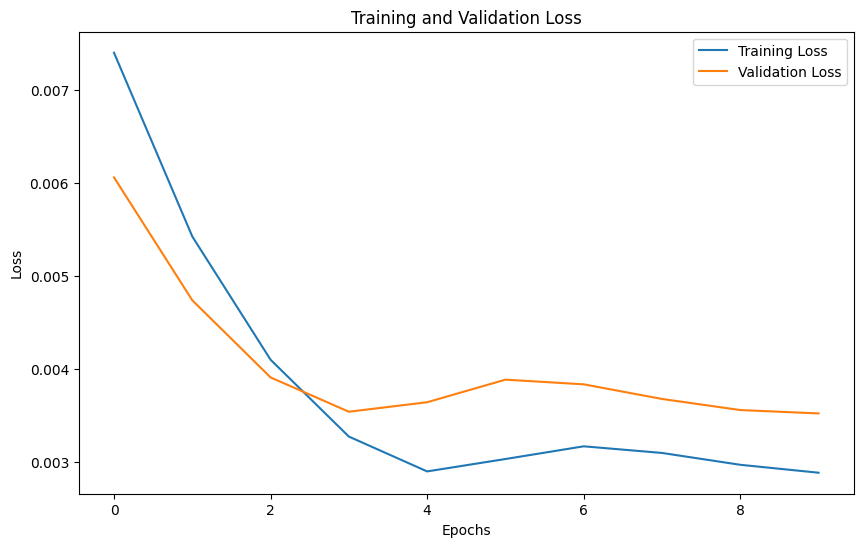

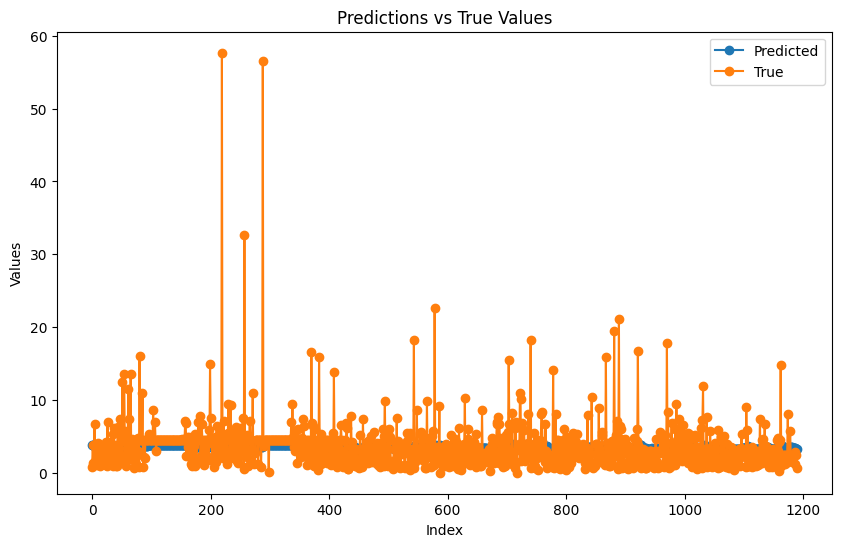


Processing unit: 4
data_split finish
data_split finish
Start training
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.0275 - val_loss: 0.0131
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0188 - val_loss: 0.0101
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0184 - val_loss: 0.0083
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0135 - val_loss: 0.0080
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0118 - val_loss: 0.0091
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0144 - val_loss: 0.0097
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0167 - val_loss: 0.0093
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0151 - val_loss: 0.0083
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0141 - val_loss: 0.0079
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0145 - val_loss: 0.0079
End training
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093
Test Loss: 0.0079
38/38 ━━━━━━

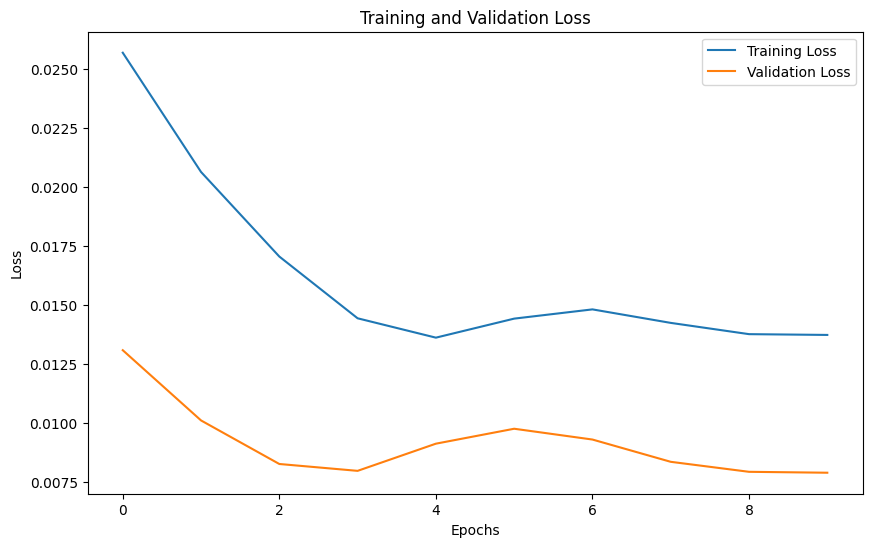

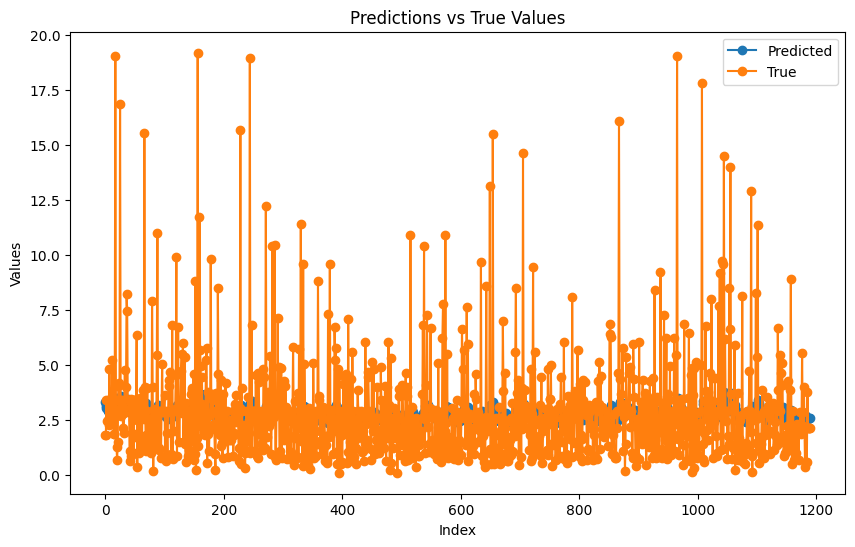


Processing unit: 5
data_split finish
data_split finish
Start training
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0172 - val_loss: 0.0111
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0116 - val_loss: 0.0084
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0090 - val_loss: 0.0068
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0097 - val_loss: 0.0077
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0097 - val_loss: 0.0071
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0095 - val_loss: 0.0068
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0092 - val_loss: 0.0067
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0081 - val_loss: 0.0068
End training
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075    
Test Loss: 0.0068
38/38 ━━

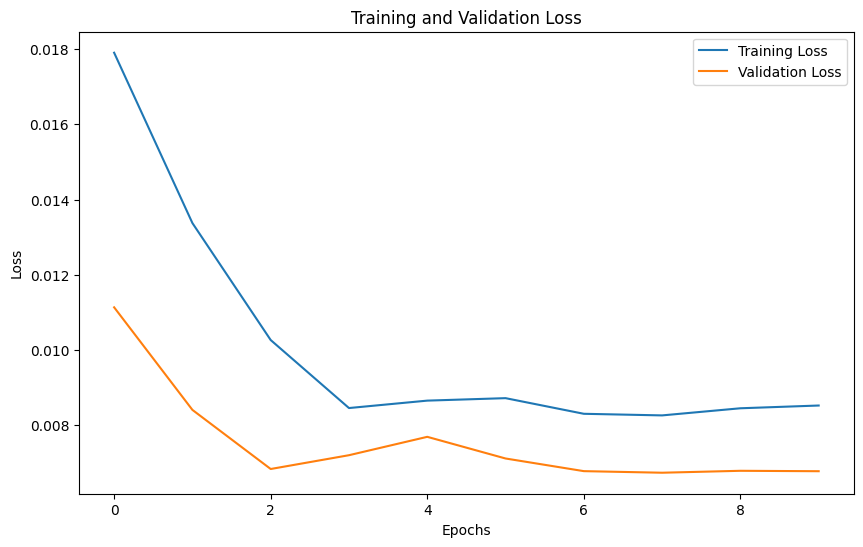

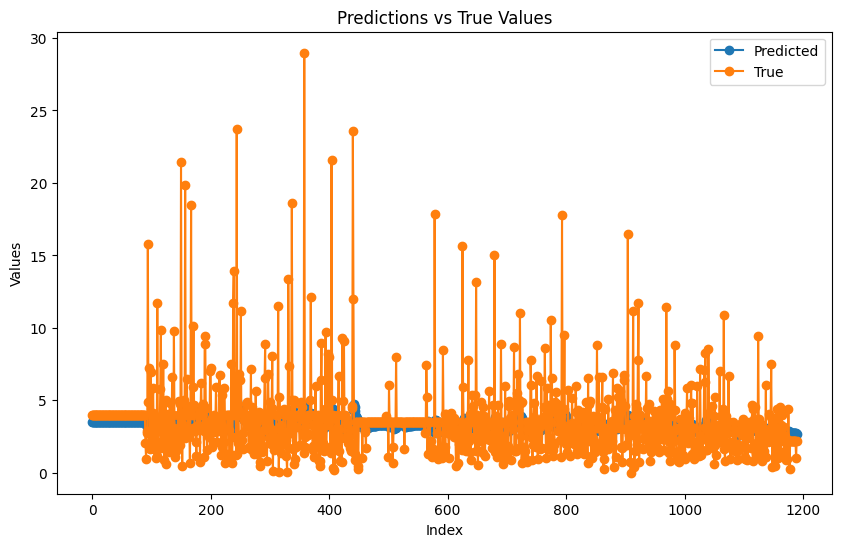

In [28]:
# Loop over each unit column
for unit in daily_average.columns:
    print(f'\nProcessing unit: {unit}')
    
    # Copy the DataFrame to avoid modifying the original data
    unit_df = daily_average[[unit]].copy()
    
    # Scale the target variable using MinMaxScaler
    scaler = MinMaxScaler()
    unit_df[unit] = scaler.fit_transform(unit_df[[unit]])

    # Create lag features for the scaled data
    scaled_df = create_features(unit_df.copy())

    # Prepare sequences for time series modeling
    X, y = create_seq(scaled_df[unit].values)

    # Reshape X for RNN input
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Split sequences into training and testing sets
    X_train, X_test = data_split(X)
    y_train, y_test = data_split(y)

    # Train and evaluate the RNN model
    create_LSTM(X_train, y_train, X_test, y_test)

## CONCLUSIONS:

* As it shows, the DL models out perform linear regressions in all the accuracy scores
* Between the LSTM and RNN there is no significant difference, indicating that using LSTM might not be needed as a simpleRNN can offer similar results
* The plots show that all models are predicting values in range from 3 to 5 while there are values that are either higher or lower and in those data points they don't perform well
* There should be further analysis and research in order to improve the work